# Unzip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/'AI & ML for Cyberattack Detection and Defense in Telecom (project)'/ddos_detection/'CSVs(1)'.zip

Archive:  /content/drive/MyDrive/AI & ML for Cyberattack Detection and Defense in Telecom (project)/ddos_detection/CSVs(1).zip
 extracting: CSVs/Monday_18_Dec_2023.csv  
 extracting: CSVs/Saturday_16_Dec_2023.csv  
 extracting: CSVs/Thursday_14_Dec_2023.csv  
 extracting: CSVs/Tuesday_19_Dec_2023.csv  


# Load data

### monday

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_csv('/content/CSVs/Monday_18_Dec_2023.csv')

In [ ]:
to_keep_features = ['flow_id','timestamp','src_ip','src_port','dst_ip','dst_port','protocol',
                    'bwd_packets_count','duration','packets_count','fwd_packets_count','label','activity']

In [ ]:
data = data[to_keep_features]

In [ ]:
root = '/content/drive/MyDrive/AI & ML for Cyberattack Detection and Defense in Telecom (project)/ddos_detection/transformed'

In [ ]:
data.to_csv(root+'/Monday_18_Dec_2023.csv',index=False)

### thursday

In [ ]:
data = pd.read_csv('/content/CSVs/Thursday_14_Dec_2023.csv')

In [ ]:
to_keep_features = ['flow_id','timestamp','src_ip','src_port','dst_ip','dst_port','protocol',
                    'bwd_packets_count','duration','packets_count','fwd_packets_count','label','activity']

In [ ]:
data = data[to_keep_features]

In [ ]:
data.to_csv(root+'/Thursday_14_Dec_2023.csv',index=False)

### tuesday

In [ ]:
data = pd.read_csv('/content/CSVs/Tuesday_19_Dec_2023.csv')

In [ ]:
to_keep_features = ['flow_id','timestamp','src_ip','src_port','dst_ip','dst_port','protocol',
                    'bwd_packets_count','duration','packets_count','fwd_packets_count','label','activity']

In [ ]:
data = data[to_keep_features]

In [ ]:
data.to_csv(root+'/Tuesday_19_Dec_2023.csv',index=False)

#NetworkFlowEDA


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from typing import List, Dict, Tuple, Optional
from sklearn.preprocessing import LabelEncoder
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

warnings.filterwarnings('ignore')

class NetworkFlowEDA:
    """
    Comprehensive EDA class for network flow data with focus on sequential modeling.
    Designed specifically for preparing data for sequential/temporal machine learning models.
    """

    def __init__(self, df: pd.DataFrame):
        """
        Initialize the EDA class with network flow data.

        Args:
            df: DataFrame containing network flow data
        """
        self.df = df.copy()
        self.original_shape = df.shape
        self.processed_df = None
        self.time_series_features = {}
        self.sequential_stats = {}

        # Set up the plotting style
        plt.style.use('default')
        sns.set_palette("husl")

        # Initialize the dataset
        self._preprocess_initial()

    def _preprocess_initial(self):
        """Initial preprocessing of the dataset."""
        print("🔄 Initializing dataset preprocessing...")

        # Convert timestamp to datetime
        if 'timestamp' in self.df.columns:
            self.df['timestamp'] = pd.to_datetime(self.df['timestamp'])
            self.df = self.df.sort_values('timestamp').reset_index(drop=True)

        # Parse flow_id components if needed
        if 'flow_id' in self.df.columns:
            self._parse_flow_id()

        print(f"✅ Dataset initialized: {self.df.shape[0]:,} rows, {self.df.shape[1]} columns")

    def _parse_flow_id(self):
        """Parse flow_id to extract additional features."""
        # Extract timestamp from flow_id if it contains one
        # Format: src_ip_src_port_dst_ip_dst_port_protocol_timestamp
        try:
            flow_parts = self.df['flow_id'].str.split('_', expand=True)
            if flow_parts.shape[1] >= 6:
                self.df['flow_protocol_from_id'] = flow_parts.iloc[:, 4]
        except Exception as e:
            print(f"⚠️ Could not parse flow_id: {e}")

    def dataset_overview(self) -> Dict:
        """
        Provide comprehensive dataset overview.

        Returns:
            Dictionary containing dataset overview statistics
        """
        print("📊 DATASET OVERVIEW")
        print("=" * 50)

        overview = {
            'shape': self.df.shape,
            'memory_usage': self.df.memory_usage(deep=True).sum() / (1024**2),  # MB
            'columns': list(self.df.columns),
            'dtypes': dict(self.df.dtypes),
            'time_range': None,
            'missing_values': dict(self.df.isnull().sum()),
            'duplicate_rows': self.df.duplicated().sum()
        }

        if 'timestamp' in self.df.columns:
            overview['time_range'] = {
                'start': self.df['timestamp'].min(),
                'end': self.df['timestamp'].max(),
                'duration': self.df['timestamp'].max() - self.df['timestamp'].min()
            }

        # Print overview
        print(f"📏 Shape: {overview['shape'][0]:,} rows × {overview['shape'][1]} columns")
        print(f"💾 Memory usage: {overview['memory_usage']:.2f} MB")
        print(f"🔄 Duplicate rows: {overview['duplicate_rows']:,}")

        if overview['time_range']:
            print(f"⏰ Time range: {overview['time_range']['start']} to {overview['time_range']['end']}")
            print(f"📅 Duration: {overview['time_range']['duration']}")

        # Missing values
        missing = pd.Series(overview['missing_values'])
        if missing.sum() > 0:
            print("\n❌ Missing values:")
            for col, count in missing[missing > 0].items():
                print(f"   {col}: {count:,} ({count/len(self.df)*100:.2f}%)")
        else:
            print("\n✅ No missing values found")

        return overview

    def analyze_labels_and_activities(self):
        """Analyze label and activity distributions."""
        print("\n🏷️ LABEL AND ACTIVITY ANALYSIS")
        print("=" * 50)

        # Label distribution
        if 'label' in self.df.columns:
            label_dist = self.df['label'].value_counts()
            print("📊 Label Distribution:")
            for label, count in label_dist.items():
                print(f"   {label}: {count:,} ({count/len(self.df)*100:.2f}%)")

        # Activity distribution
        if 'activity' in self.df.columns:
            activity_dist = self.df['activity'].value_counts()
            print(f"\n🎯 Activity Distribution ({len(activity_dist)} unique activities):")
            for activity, count in activity_dist.head(10).items():
                print(f"   {activity}: {count:,} ({count/len(self.df)*100:.2f}%)")

            if len(activity_dist) > 10:
                print(f"   ... and {len(activity_dist) - 10} more activities")

        # Create visualizations
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        # Label distribution pie chart
        if 'label' in self.df.columns:
            label_dist.plot(kind='pie', ax=axes[0], autopct='%1.1f%%')
            axes[0].set_title('Label Distribution')
            axes[0].set_ylabel('')

        # Top activities bar chart
        if 'activity' in self.df.columns:
            activity_dist.head(10).plot(kind='barh', ax=axes[1])
            axes[1].set_title('Top 10 Activities')
            axes[1].set_xlabel('Count')

        plt.tight_layout()
        plt.show()

    def time_series_analysis(self):
        """
        Comprehensive time series analysis for sequential modeling.
        """
        print("\n⏰ TIME SERIES ANALYSIS")
        print("=" * 50)

        if 'timestamp' not in self.df.columns:
            print("❌ No timestamp column found for time series analysis")
            return

        # Basic time series statistics
        time_stats = {
            'total_duration': self.df['timestamp'].max() - self.df['timestamp'].min(),
            'avg_time_between_flows': self.df['timestamp'].diff().mean(),
            'min_time_gap': self.df['timestamp'].diff().min(),
            'max_time_gap': self.df['timestamp'].diff().max(),
        }

        print(f"📅 Total duration: {time_stats['total_duration']}")
        print(f"⚡ Average time between flows: {time_stats['avg_time_between_flows']}")
        print(f"🏃 Minimum time gap: {time_stats['min_time_gap']}")
        print(f"🐌 Maximum time gap: {time_stats['max_time_gap']}")

        # Create time-based aggregations for different granularities
        self._analyze_temporal_patterns()
        self._analyze_attack_patterns_over_time()
        self._analyze_sequential_characteristics()

        self.time_series_features = time_stats

    def _analyze_temporal_patterns(self):
        """Analyze patterns at different time granularities."""
        print("\n📈 Temporal Patterns Analysis:")

        # Create time-based features
        self.df['hour'] = self.df['timestamp'].dt.hour
        self.df['day_of_week'] = self.df['timestamp'].dt.dayofweek
        self.df['minute'] = self.df['timestamp'].dt.minute

        # Hourly patterns
        hourly_counts = self.df.groupby('hour').size()
        daily_patterns = self.df.groupby('day_of_week').size()

        # Attack patterns by time
        if 'label' in self.df.columns:
            hourly_attacks = self.df[self.df['label'] == 'Attack'].groupby('hour').size()
            attack_ratio_by_hour = (hourly_attacks / hourly_counts * 100).fillna(0)

            print(f"🔍 Peak traffic hour: {hourly_counts.idxmax()}:00 ({hourly_counts.max():,} flows)")
            print(f"🎯 Peak attack hour: {hourly_attacks.idxmax()}:00 ({hourly_attacks.max():,} attacks)")
            print(f"⚠️ Highest attack ratio: {attack_ratio_by_hour.idxmax()}:00 ({attack_ratio_by_hour.max():.2f}%)")

        # Visualizations
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Hourly traffic
        hourly_counts.plot(kind='bar', ax=axes[0,0], color='skyblue')
        axes[0,0].set_title('Traffic by Hour of Day')
        axes[0,0].set_xlabel('Hour')
        axes[0,0].set_ylabel('Flow Count')
        axes[0,0].tick_params(axis='x', rotation=45)

        # Daily patterns
        daily_patterns.plot(kind='bar', ax=axes[0,1], color='lightgreen')
        axes[0,1].set_title('Traffic by Day of Week (0=Monday)')
        axes[0,1].set_xlabel('Day of Week')
        axes[0,1].set_ylabel('Flow Count')

        # Attack patterns by hour
        if 'label' in self.df.columns:
            attack_ratio_by_hour.plot(kind='line', ax=axes[1,0], color='red', marker='o')
            axes[1,0].set_title('Attack Ratio by Hour')
            axes[1,0].set_xlabel('Hour')
            axes[1,0].set_ylabel('Attack Ratio (%)')
            axes[1,0].grid(True)

        # Time gaps between flows
        time_gaps = self.df['timestamp'].diff().dt.total_seconds()
        time_gaps = time_gaps[time_gaps > 0]  # Remove NaN and negative values
        axes[1,1].hist(time_gaps, bins=50, alpha=0.7, color='orange')
        axes[1,1].set_title('Distribution of Time Gaps Between Flows')
        axes[1,1].set_xlabel('Time Gap (seconds)')
        axes[1,1].set_ylabel('Frequency')
        axes[1,1].set_yscale('log')

        plt.tight_layout()
        plt.show()

    def _analyze_attack_patterns_over_time(self):
        """Analyze how attacks are distributed over time."""
        if 'label' not in self.df.columns:
            return

        print("\n🚨 Attack Patterns Over Time:")

        # Resample to different time windows
        self.df.set_index('timestamp', inplace=True)

        # 1-minute windows
        attacks_1min = self.df[self.df['label'] == 'Attack'].resample('1T').size()
        total_1min = self.df.resample('1T').size()
        attack_ratio_1min = (attacks_1min / total_1min * 100).fillna(0)

        # 5-minute windows
        attacks_5min = self.df[self.df['label'] == 'Attack'].resample('5T').size()
        total_5min = self.df.resample('5T').size()
        attack_ratio_5min = (attacks_5min / total_5min * 100).fillna(0)

        # Reset index
        self.df.reset_index(inplace=True)

        print(f"📊 1-minute windows with attacks: {(attacks_1min > 0).sum():,}")
        print(f"📊 5-minute windows with attacks: {(attacks_5min > 0).sum():,}")
        print(f"🔥 Max attacks in 1-minute window: {attacks_1min.max()}")
        print(f"🔥 Max attacks in 5-minute window: {attacks_5min.max()}")

        # Plot attack patterns
        fig, axes = plt.subplots(2, 1, figsize=(15, 10))

        # Attacks over time (1-minute resolution)
        attacks_1min.plot(ax=axes[0], color='red', alpha=0.7)
        axes[0].set_title('Attacks Over Time (1-minute windows)')
        axes[0].set_ylabel('Attack Count')
        axes[0].grid(True)

        # Attack ratio over time (5-minute resolution)
        attack_ratio_5min.plot(ax=axes[1], color='orange', alpha=0.8)
        axes[1].set_title('Attack Ratio Over Time (5-minute windows)')
        axes[1].set_ylabel('Attack Ratio (%)')
        axes[1].grid(True)

        plt.tight_layout()
        plt.show()

    def _analyze_sequential_characteristics(self):
        """Analyze characteristics important for sequential modeling."""
        print("\n🔗 Sequential Characteristics Analysis:")

        # Analyze consecutive patterns
        if 'label' in self.df.columns:
            # Label transitions
            label_transitions = {}
            for i in range(len(self.df) - 1):
                current_label = self.df.iloc[i]['label']
                next_label = self.df.iloc[i + 1]['label']
                transition = f"{current_label} → {next_label}"
                label_transitions[transition] = label_transitions.get(transition, 0) + 1

            print("🔄 Most common label transitions:")
            sorted_transitions = sorted(label_transitions.items(), key=lambda x: x[1], reverse=True)
            for transition, count in sorted_transitions[:10]:
                print(f"   {transition}: {count:,}")

            # Consecutive attack sequences
            attack_sequences = []
            current_sequence = 0
            for label in self.df['label']:
                if label == 'Attack':
                    current_sequence += 1
                else:
                    if current_sequence > 0:
                        attack_sequences.append(current_sequence)
                    current_sequence = 0

            if current_sequence > 0:  # Handle case where data ends with attacks
                attack_sequences.append(current_sequence)

            if attack_sequences:
                print(f"\n⚡ Attack sequence analysis:")
                print(f"   Total attack sequences: {len(attack_sequences):,}")
                print(f"   Average sequence length: {np.mean(attack_sequences):.2f}")
                print(f"   Longest attack sequence: {max(attack_sequences):,}")
                print(f"   Sequences longer than 10: {sum(1 for seq in attack_sequences if seq > 10):,}")

        # Time gap analysis for sequential modeling
        time_gaps = self.df['timestamp'].diff().dt.total_seconds()
        time_gaps = time_gaps[time_gaps > 0]

        print(f"\n⏱️ Time gap statistics (for window sizing):")
        print(f"   Mean gap: {time_gaps.mean():.2f} seconds")
        print(f"   Median gap: {time_gaps.median():.2f} seconds")
        print(f"   95th percentile: {time_gaps.quantile(0.95):.2f} seconds")
        print(f"   99th percentile: {time_gaps.quantile(0.99):.2f} seconds")

        self.sequential_stats = {
            'label_transitions': label_transitions if 'label' in self.df.columns else {},
            'attack_sequences': attack_sequences if 'label' in self.df.columns else [],
            'time_gap_stats': {
                'mean': time_gaps.mean(),
                'median': time_gaps.median(),
                'p95': time_gaps.quantile(0.95),
                'p99': time_gaps.quantile(0.99)
            }
        }

    def analyze_network_features(self):
        """Analyze network-specific features."""
        print("\n🌐 NETWORK FEATURES ANALYSIS")
        print("=" * 50)

        # Protocol analysis
        if 'protocol' in self.df.columns:
            protocol_dist = self.df['protocol'].value_counts()
            print("📡 Protocol Distribution:")
            for protocol, count in protocol_dist.items():
                print(f"   {protocol}: {count:,} ({count/len(self.df)*100:.2f}%)")

        # Port analysis
        self._analyze_ports()

        # IP analysis
        self._analyze_ips()

        # Flow characteristics
        self._analyze_flow_characteristics()

    def _analyze_ports(self):
        """Analyze source and destination ports."""
        print(f"\n🔌 Port Analysis:")

        for port_type in ['src_port', 'dst_port']:
            if port_type in self.df.columns:
                port_counts = self.df[port_type].value_counts()
                print(f"\n   Top 10 {port_type.replace('_', ' ')}s:")
                for port, count in port_counts.head(10).items():
                    print(f"      {port}: {count:,}")

                # Well-known ports (0-1023)
                well_known = self.df[self.df[port_type] <= 1023][port_type].value_counts()
                print(f"   Well-known ports ({port_type}): {len(well_known)} unique")

                # High ports (>1023)
                high_ports = len(self.df[self.df[port_type] > 1023][port_type].unique())
                print(f"   High ports ({port_type}): {high_ports} unique")

    def _analyze_ips(self):
        """Analyze IP addresses."""
        print(f"\n🖥️ IP Analysis:")

        for ip_type in ['src_ip', 'dst_ip']:
            if ip_type in self.df.columns:
                ip_counts = self.df[ip_type].value_counts()
                print(f"\n   {ip_type.replace('_', ' ').title()} statistics:")
                print(f"      Unique IPs: {len(ip_counts):,}")
                print(f"      Most active IP: {ip_counts.index[0]} ({ip_counts.iloc[0]:,} flows)")

                # Identify internal vs external IPs (common private ranges)
                internal_patterns = ['10.', '192.168.', '172.16.', '172.17.', '172.18.', '172.19.',
                                   '172.20.', '172.21.', '172.22.', '172.23.', '172.24.', '172.25.',
                                   '172.26.', '172.27.', '172.28.', '172.29.', '172.30.', '172.31.']

                internal_ips = 0
                for pattern in internal_patterns:
                    internal_ips += self.df[ip_type].str.startswith(pattern).sum()

                external_ips = len(self.df) - internal_ips
                print(f"      Internal IPs: {internal_ips:,} ({internal_ips/len(self.df)*100:.2f}%)")
                print(f"      External IPs: {external_ips:,} ({external_ips/len(self.df)*100:.2f}%)")

    def _analyze_flow_characteristics(self):
        """Analyze flow-level characteristics."""
        print(f"\n📊 Flow Characteristics:")

        numerical_columns = ['duration', 'packets_count', 'fwd_packets_count', 'bwd_packets_count']

        for col in numerical_columns:
            if col in self.df.columns:
                stats = self.df[col].describe()
                print(f"\n   {col.replace('_', ' ').title()}:")
                print(f"      Mean: {stats['mean']:.4f}")
                print(f"      Median: {stats['50%']:.4f}")
                print(f"      Std: {stats['std']:.4f}")
                print(f"      Min: {stats['min']:.4f}")
                print(f"      Max: {stats['max']:.4f}")

        # Visualize distributions
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.ravel()

        for i, col in enumerate(numerical_columns[:4]):
            if col in self.df.columns:
                # Use log scale for better visualization
                data = self.df[col][self.df[col] > 0]  # Remove zeros for log scale
                if len(data) > 0:
                    axes[i].hist(np.log10(data + 1), bins=50, alpha=0.7)
                    axes[i].set_title(f'Distribution of {col.replace("_", " ").title()} (log scale)')
                    axes[i].set_xlabel(f'Log10({col.replace("_", " ")})')
                    axes[i].set_ylabel('Frequency')

        plt.tight_layout()
        plt.show()

    def correlation_analysis(self):
        """Analyze correlations between numerical features."""
        print("\n🔗 CORRELATION ANALYSIS")
        print("=" * 50)

        # Select numerical columns
        numerical_cols = self.df.select_dtypes(include=[np.number]).columns.tolist()

        if len(numerical_cols) < 2:
            print("❌ Not enough numerical columns for correlation analysis")
            return

        # Calculate correlation matrix
        corr_matrix = self.df[numerical_cols].corr()

        # Find highly correlated pairs
        high_corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                corr_val = corr_matrix.iloc[i, j]
                if abs(corr_val) > 0.7:  # Threshold for high correlation
                    high_corr_pairs.append((corr_matrix.columns[i],
                                          corr_matrix.columns[j],
                                          corr_val))

        print("🔍 Highly correlated feature pairs (|correlation| > 0.7):")
        for col1, col2, corr_val in high_corr_pairs:
            print(f"   {col1} ↔ {col2}: {corr_val:.3f}")

        # Visualize correlation matrix
        plt.figure(figsize=(10, 8))
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                    square=True, linewidths=0.5, cbar_kws={"shrink": 0.5})
        plt.title('Feature Correlation Matrix')
        plt.tight_layout()
        plt.show()

    def prepare_sequential_windows(self, window_size: int = 100, step_size: int = 50,
                                 target_column: str = 'label') -> Dict:
        """
        Prepare data for sequential modeling by creating time-based windows.

        Args:
            window_size: Number of flows per window
            step_size: Step size for sliding window
            target_column: Column to use as target

        Returns:
            Dictionary with window statistics and recommendations
        """
        print(f"\n🪟 PREPARING SEQUENTIAL WINDOWS")
        print("=" * 50)
        print(f"Window size: {window_size}, Step size: {step_size}")

        # Sort by timestamp
        df_sorted = self.df.sort_values('timestamp').reset_index(drop=True)

        # Create windows
        windows = []
        window_labels = []
        window_timestamps = []

        for i in range(0, len(df_sorted) - window_size + 1, step_size):
            window_data = df_sorted.iloc[i:i + window_size]
            windows.append(window_data)

            # Window label (majority vote or last label)
            if target_column in df_sorted.columns:
                window_label = window_data[target_column].mode().iloc[0]
                window_labels.append(window_label)

            # Window timestamp (start of window)
            window_timestamps.append(window_data['timestamp'].iloc[0])

        # Analyze window characteristics
        window_stats = {
            'total_windows': len(windows),
            'window_size': window_size,
            'step_size': step_size,
            'overlap_ratio': (window_size - step_size) / window_size if step_size < window_size else 0,
            'time_span_per_window': [],
            'label_distribution': {}
        }

        # Calculate time spans
        for window in windows:
            time_span = (window['timestamp'].max() - window['timestamp'].min()).total_seconds()
            window_stats['time_span_per_window'].append(time_span)

        # Label distribution across windows
        if window_labels:
            label_dist = pd.Series(window_labels).value_counts()
            window_stats['label_distribution'] = dict(label_dist)

        print(f"✅ Created {len(windows):,} windows")
        print(f"📊 Overlap ratio: {window_stats['overlap_ratio']:.2f}")
        print(f"⏱️ Average time span per window: {np.mean(window_stats['time_span_per_window']):.2f} seconds")

        if window_labels:
            print("\n🏷️ Window label distribution:")
            for label, count in window_stats['label_distribution'].items():
                print(f"   {label}: {count:,} windows ({count/len(windows)*100:.2f}%)")

        # Recommendations for sequential modeling
        print(f"\n💡 RECOMMENDATIONS FOR SEQUENTIAL MODELING:")

        avg_time_gap = self.sequential_stats.get('time_gap_stats', {}).get('mean', 0)
        avg_window_time = np.mean(window_stats['time_span_per_window'])

        print(f"📏 Current window covers ~{avg_window_time:.0f} seconds on average")
        print(f"⚡ Average time between flows: {avg_time_gap:.2f} seconds")

        # Window size recommendations
        if avg_time_gap > 0:
            flows_per_minute = 60 / avg_time_gap
            recommended_1min = int(flows_per_minute)
            recommended_5min = int(flows_per_minute * 5)

            print(f"🎯 Recommended window sizes:")
            print(f"   For 1-minute windows: ~{recommended_1min} flows")
            print(f"   For 5-minute windows: ~{recommended_5min} flows")

        # Class imbalance analysis
        if window_labels:
            label_counts = pd.Series(window_labels).value_counts()
            min_class_ratio = label_counts.min() / label_counts.max()

            if min_class_ratio < 0.1:
                print(f"⚠️ Severe class imbalance detected (ratio: {min_class_ratio:.3f})")
                print("   Consider stratified sampling or class weighting")
            elif min_class_ratio < 0.3:
                print(f"⚠️ Moderate class imbalance (ratio: {min_class_ratio:.3f})")

        return window_stats

    def generate_report(self) -> str:
        """Generate a comprehensive EDA report."""
        report = []
        report.append("📋 NETWORK FLOW EDA REPORT")
        report.append("=" * 50)
        report.append(f"Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        report.append(f"Dataset shape: {self.df.shape[0]:,} rows × {self.df.shape[1]} columns")

        if 'timestamp' in self.df.columns:
            time_range = self.df['timestamp'].max() - self.df['timestamp'].min()
            report.append(f"Time range: {time_range}")

        if 'label' in self.df.columns:
            label_dist = self.df['label'].value_counts()
            report.append(f"\nLabel distribution:")
            for label, count in label_dist.items():
                report.append(f"  {label}: {count:,} ({count/len(self.df)*100:.2f}%)")

        # Add sequential modeling insights
        if hasattr(self, 'sequential_stats') and self.sequential_stats:
            report.append(f"\nSequential characteristics:")
            if 'time_gap_stats' in self.sequential_stats:
                stats = self.sequential_stats['time_gap_stats']
                report.append(f"  Mean time gap: {stats['mean']:.2f}s")
                report.append(f"  Median time gap: {stats['median']:.2f}s")

            if 'attack_sequences' in self.sequential_stats:
                sequences = self.sequential_stats['attack_sequences']
                if sequences:
                    report.append(f"  Attack sequences found: {len(sequences)}")
                    report.append(f"  Average sequence length: {np.mean(sequences):.2f}")

        return "\n".join(report)

    def run_complete_eda(self):
        """Run all EDA components in sequence."""
        print("🚀 STARTING COMPREHENSIVE EDA FOR SEQUENTIAL MODELING")
        print("=" * 70)

        # Basic overview
        self.dataset_overview()

        # Label and activity analysis
        self.analyze_labels_and_activities()

        # Time series analysis
        self.time_series_analysis()

        # Network features
        self.analyze_network_features()

        # Correlation analysis
        self.correlation_analysis()

        # Sequential windows preparation
        self.prepare_sequential_windows()

        # Generate final report
        print("\n" + "="*70)
        print(self.generate_report())
        print("="*70)
        print("✅ EDA COMPLETE! Ready for sequential modeling.")



# Eda

### monday

In [ ]:
data = pd.read_csv('/content/CSVs/Monday_18_Dec_2023.csv')

In [ ]:
to_keep_features = ['flow_id','timestamp','src_ip','src_port','dst_ip','dst_port','protocol',
                    'bwd_packets_count','duration','packets_count','fwd_packets_count','label','activity']

In [ ]:
data = data[to_keep_features]

In [ ]:
data.to_csv(root+'/Monday_18_Dec_2023.csv',index=False)

🔄 Initializing dataset preprocessing...
✅ Dataset initialized: 320,530 rows, 14 columns
🚀 STARTING COMPREHENSIVE EDA FOR SEQUENTIAL MODELING
📊 DATASET OVERVIEW
📏 Shape: 320,530 rows × 14 columns
💾 Memory usage: 158.38 MB
🔄 Duplicate rows: 72
⏰ Time range: 2023-12-18 08:56:39.178993 to 2023-12-18 17:00:11.846422
📅 Duration: 0 days 08:03:32.667429

❌ Missing values:
   timestamp: 2 (0.00%)

🏷️ LABEL AND ACTIVITY ANALYSIS
📊 Label Distribution:
   Attack: 220,276 (68.72%)
   Benign: 68,444 (21.35%)
   Suspicious: 31,810 (9.92%)

🎯 Activity Distribution (21 unique activities):
   Attack-TCP-BYPass-V1: 138,368 (43.17%)
   Suspicious: 31,810 (9.92%)
   Benign: 28,746 (8.97%)
   Benign-Web_Browsing_HTTP-S: 21,114 (6.59%)
   Benign-Systemic: 17,590 (5.49%)
   Attack-TCP-Flag-ACK: 10,683 (3.33%)
   Attack-TCP-Flag-SYN-ACK: 8,204 (2.56%)
   Attack-TCP-Valid-SYN: 8,043 (2.51%)
   Attack-TCP-Flag-SYN: 7,845 (2.45%)
   Attack-TCP-Flag-ACK-PSH: 7,482 (2.33%)
   ... and 11 more activities


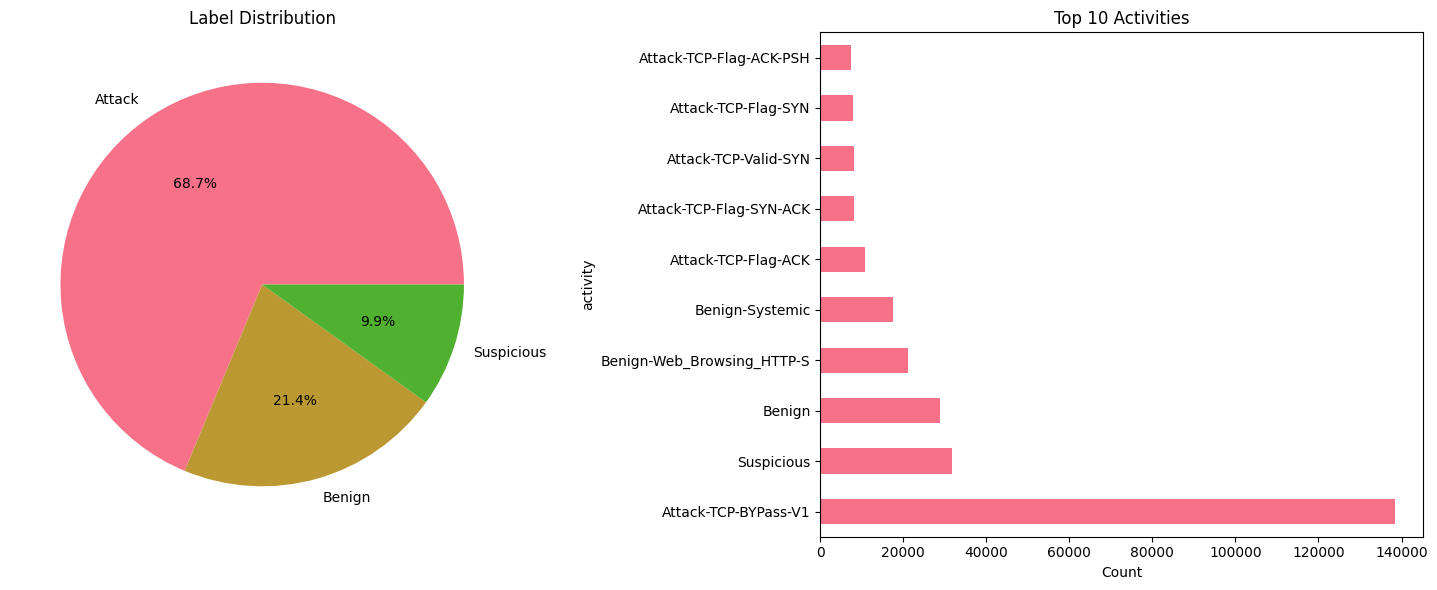


⏰ TIME SERIES ANALYSIS
📅 Total duration: 0 days 08:03:32.667429
⚡ Average time between flows: 0 days 00:00:00.090515517
🏃 Minimum time gap: 0 days 00:00:00
🐌 Maximum time gap: 0 days 00:00:06.114882

📈 Temporal Patterns Analysis:
🔍 Peak traffic hour: 9.0:00 (155,180 flows)
🎯 Peak attack hour: 9.0:00 (145,622 attacks)
⚠️ Highest attack ratio: 9.0:00 (93.84%)


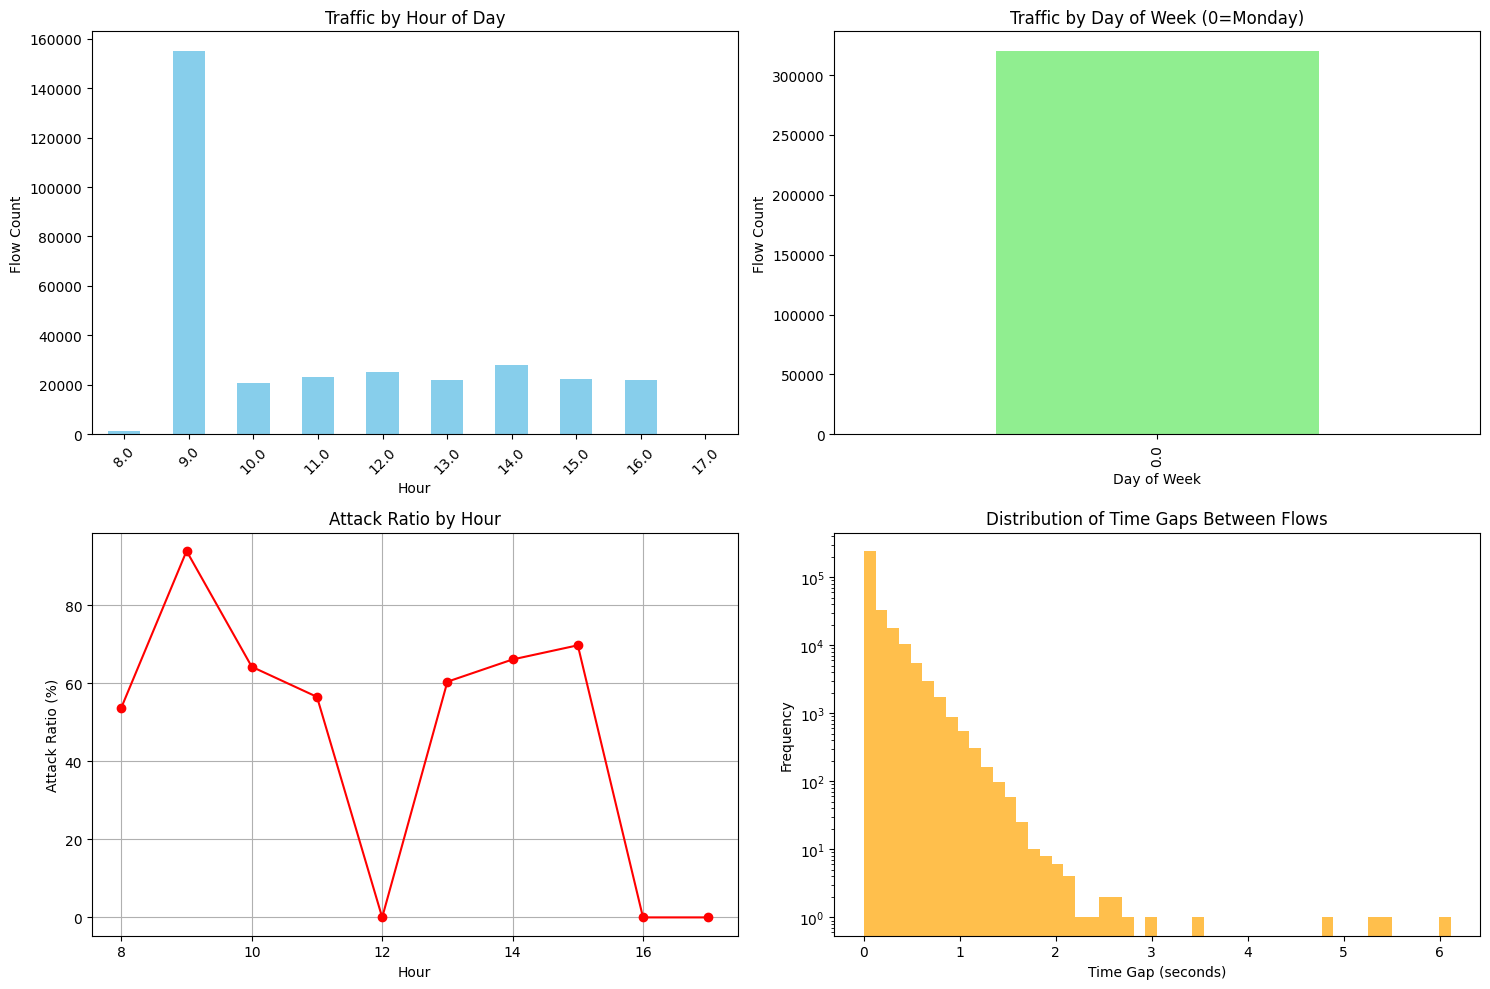


🚨 Attack Patterns Over Time:
📊 1-minute windows with attacks: 364
📊 5-minute windows with attacks: 73
🔥 Max attacks in 1-minute window: 78498
🔥 Max attacks in 5-minute window: 118370


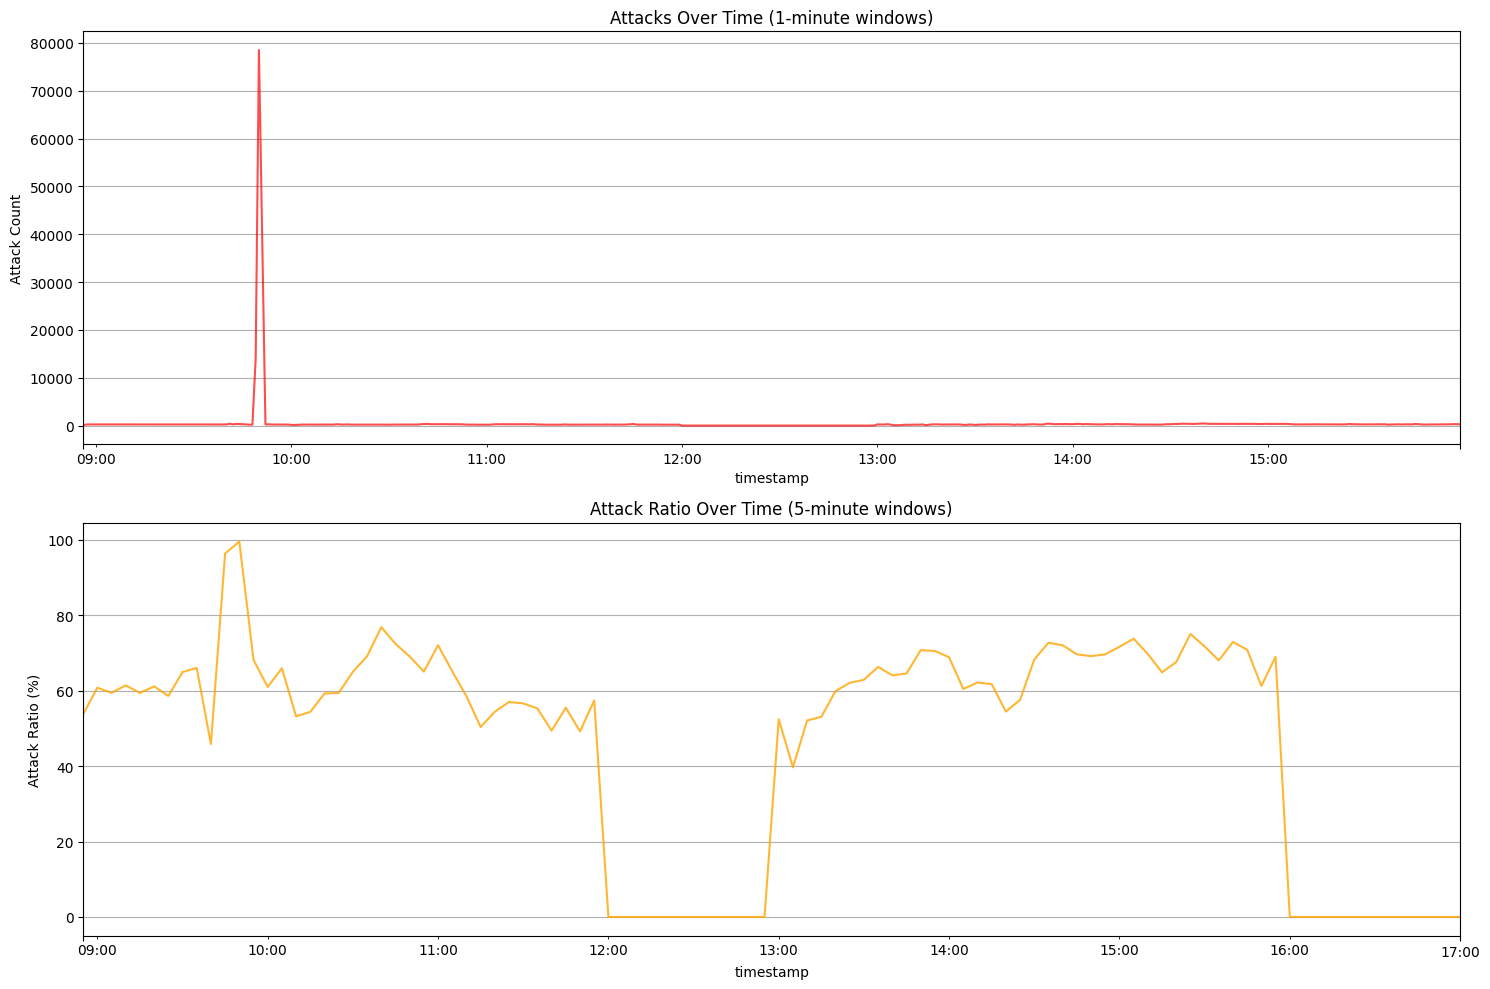


🔗 Sequential Characteristics Analysis:
🔄 Most common label transitions:
   Attack → Attack: 193,301
   Benign → Benign: 33,133
   Benign → Attack: 26,972
   Attack → Benign: 26,970
   Suspicious → Suspicious: 23,466
   Suspicious → Benign: 8,341
   Benign → Suspicious: 8,339
   Attack → Suspicious: 5
   Suspicious → Attack: 2

⚡ Attack sequence analysis:
   Total attack sequences: 26,975
   Average sequence length: 8.17
   Longest attack sequence: 4,631
   Sequences longer than 10: 753

⏱️ Time gap statistics (for window sizing):
   Mean gap: 0.09 seconds
   Median gap: 0.01 seconds
   95th percentile: 0.44 seconds
   99th percentile: 0.77 seconds

🌐 NETWORK FEATURES ANALYSIS
📡 Protocol Distribution:
   TCP: 320,530 (100.00%)

🔌 Port Analysis:

   Top 10 src ports:
      3389: 20,442
      443: 3,851
      41063: 1,338
      50083: 929
      53252: 921
      44938: 726
      56431: 703
      41057: 637
      41051: 552
      53416: 540
   Well-known ports (src_port): 9 unique
   High 

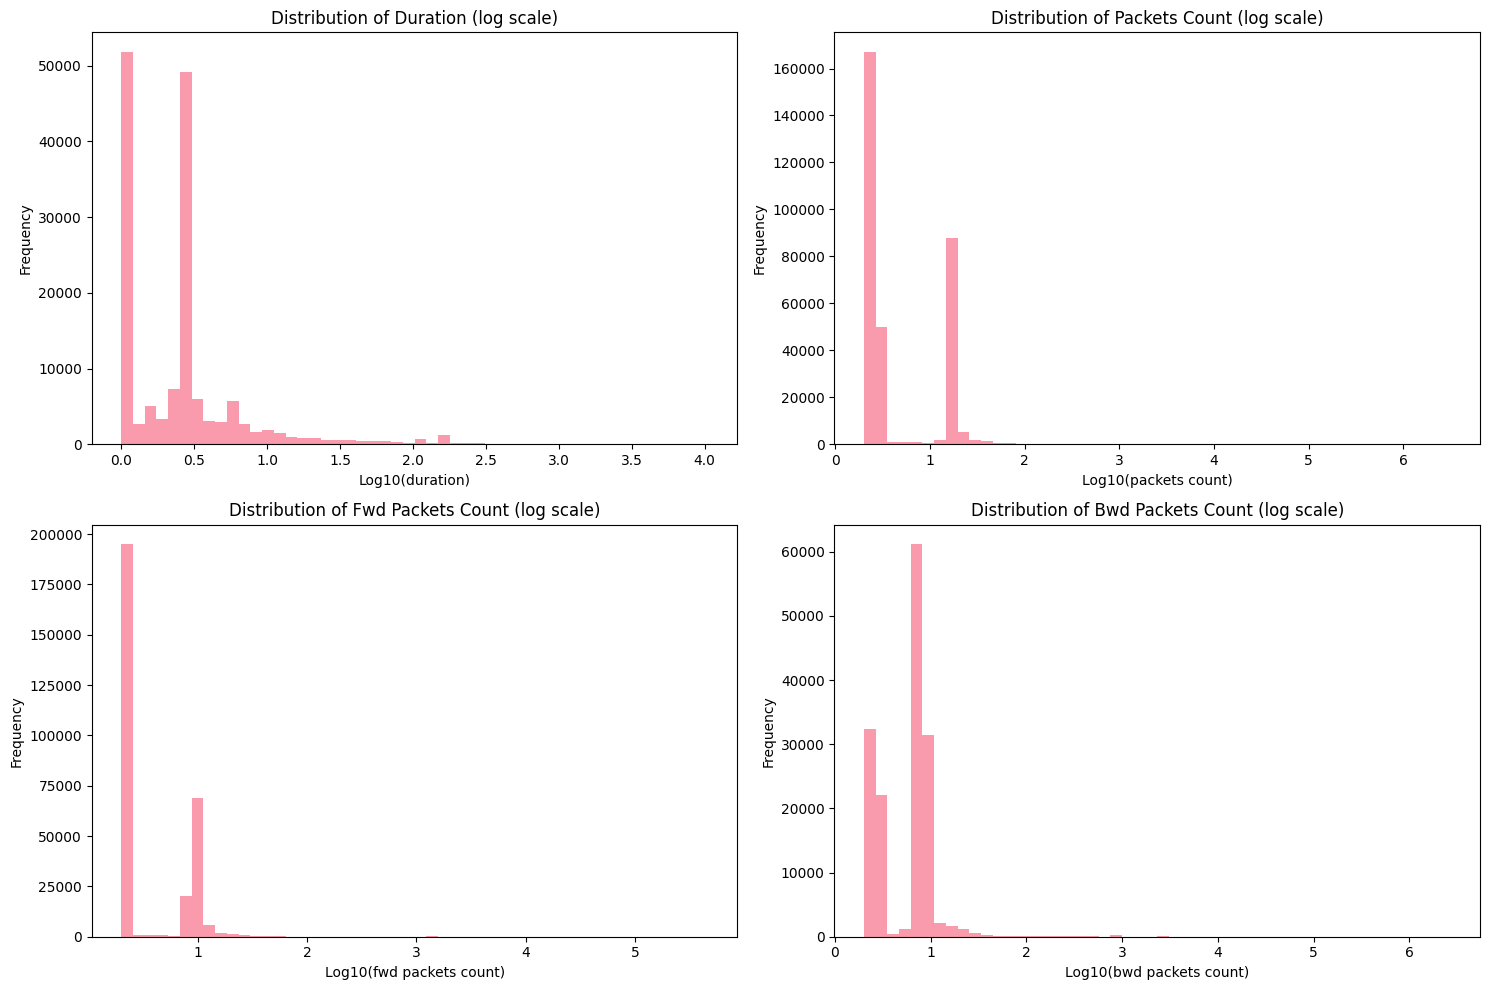


🔗 CORRELATION ANALYSIS
🔍 Highly correlated feature pairs (|correlation| > 0.7):
   bwd_packets_count ↔ packets_count: 0.999
   bwd_packets_count ↔ fwd_packets_count: 0.949
   packets_count ↔ fwd_packets_count: 0.962


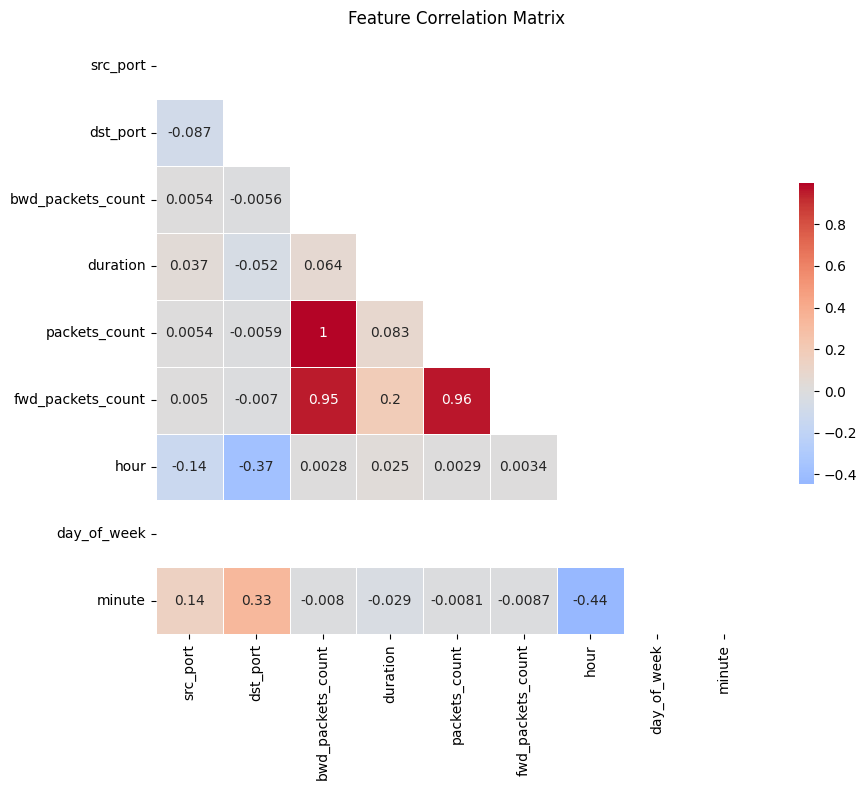


🪟 PREPARING SEQUENTIAL WINDOWS
Window size: 100, Step size: 50
✅ Created 6,409 windows
📊 Overlap ratio: 0.50
⏱️ Average time span per window: 8.96 seconds

🏷️ Window label distribution:
   Attack: 5,212 windows (81.32%)
   Suspicious: 876 windows (13.67%)
   Benign: 321 windows (5.01%)

💡 RECOMMENDATIONS FOR SEQUENTIAL MODELING:
📏 Current window covers ~9 seconds on average
⚡ Average time between flows: 0.09 seconds
🎯 Recommended window sizes:
   For 1-minute windows: ~652 flows
   For 5-minute windows: ~3261 flows
⚠️ Severe class imbalance detected (ratio: 0.062)
   Consider stratified sampling or class weighting

📋 NETWORK FLOW EDA REPORT
Generated on: 2025-09-30 08:29:45
Dataset shape: 320,530 rows × 17 columns
Time range: 0 days 08:03:32.667429

Label distribution:
  Attack: 220,276 (68.72%)
  Benign: 68,444 (21.35%)
  Suspicious: 31,810 (9.92%)

Sequential characteristics:
  Mean time gap: 0.09s
  Median time gap: 0.01s
  Attack sequences found: 26975
  Average sequence length: 8

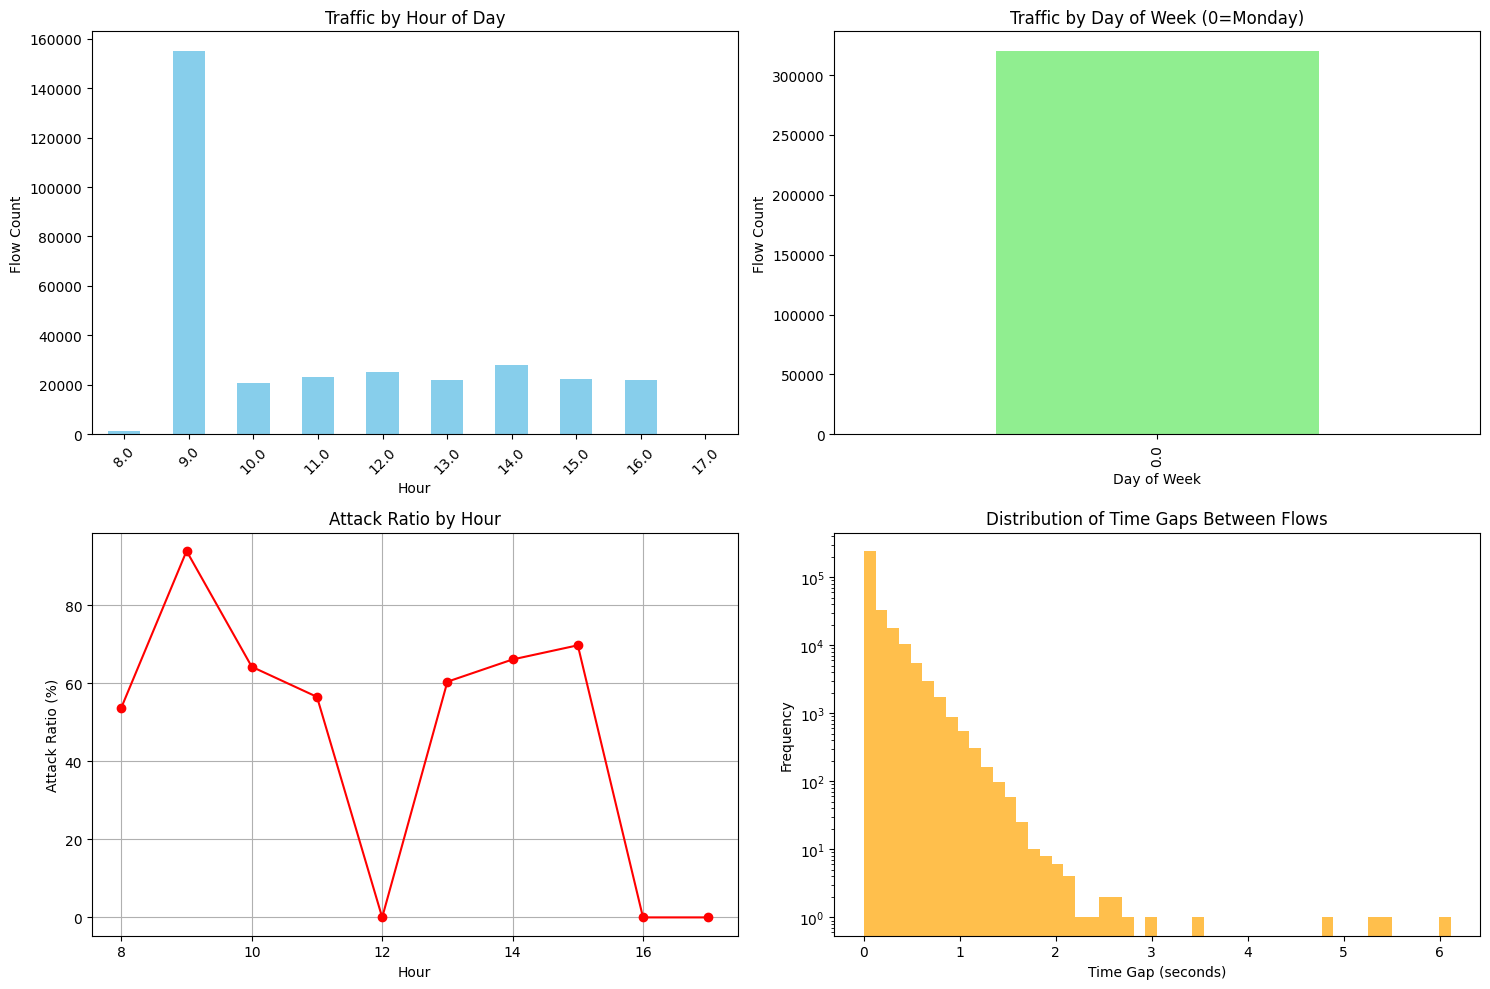


🚨 Attack Patterns Over Time:
📊 1-minute windows with attacks: 364
📊 5-minute windows with attacks: 73
🔥 Max attacks in 1-minute window: 78498
🔥 Max attacks in 5-minute window: 118370


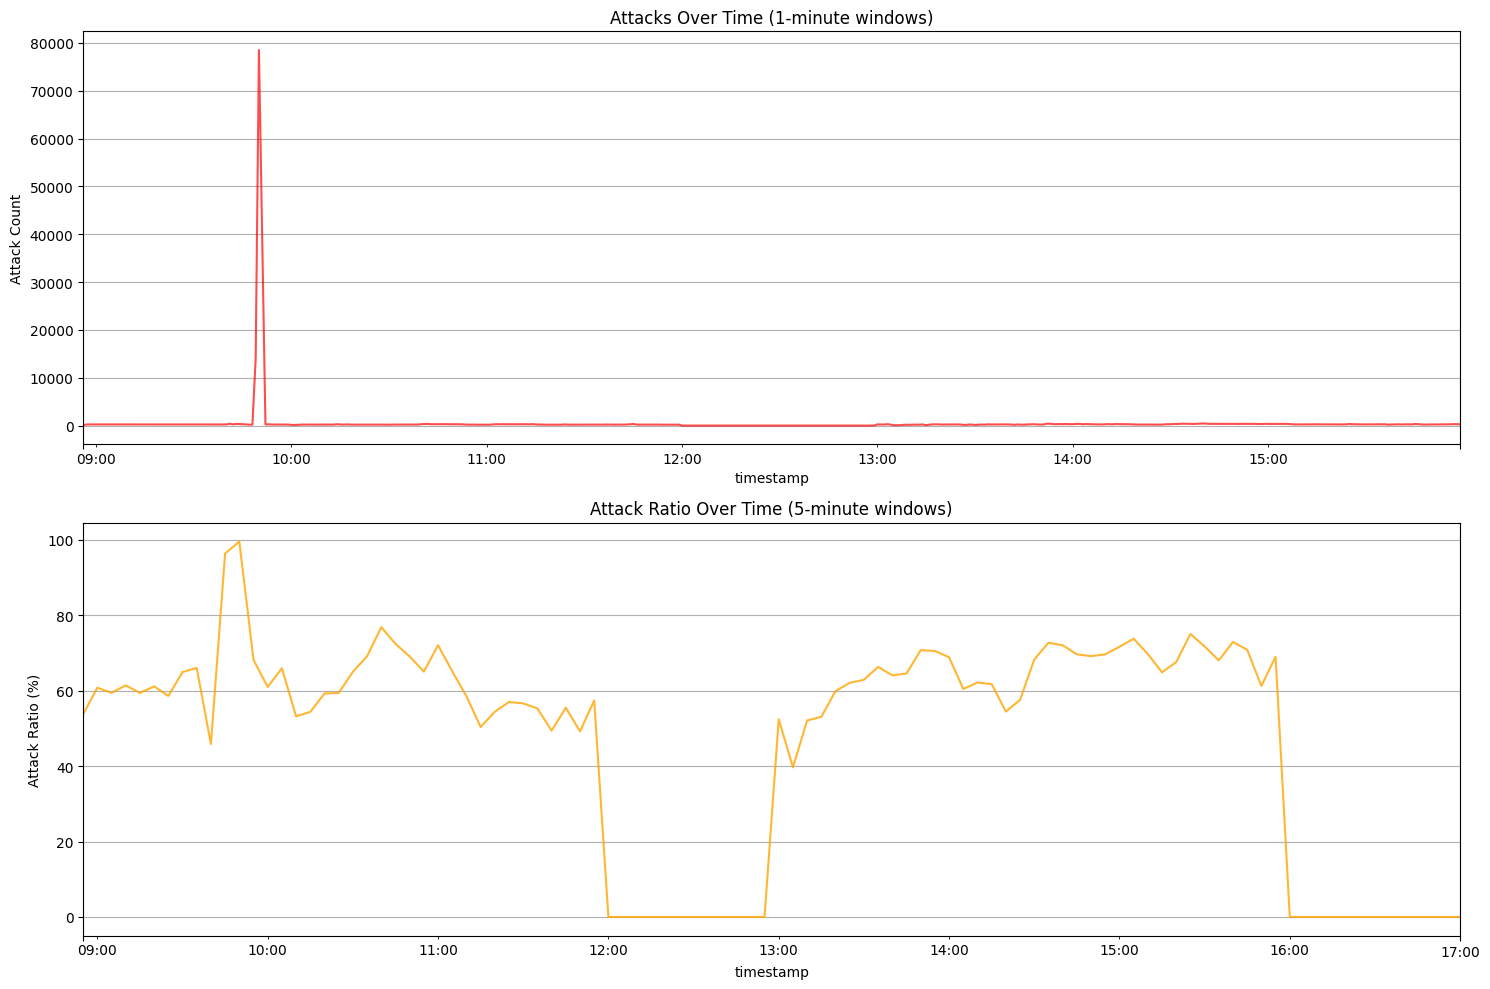


🔗 Sequential Characteristics Analysis:
🔄 Most common label transitions:
   Attack → Attack: 193,301
   Benign → Benign: 33,133
   Benign → Attack: 26,972
   Attack → Benign: 26,970
   Suspicious → Suspicious: 23,466
   Suspicious → Benign: 8,341
   Benign → Suspicious: 8,339
   Attack → Suspicious: 5
   Suspicious → Attack: 2

⚡ Attack sequence analysis:
   Total attack sequences: 26,975
   Average sequence length: 8.17
   Longest attack sequence: 4,631
   Sequences longer than 10: 753

⏱️ Time gap statistics (for window sizing):
   Mean gap: 0.09 seconds
   Median gap: 0.01 seconds
   95th percentile: 0.44 seconds
   99th percentile: 0.77 seconds

🪟 PREPARING SEQUENTIAL WINDOWS
Window size: 200, Step size: 100
✅ Created 3,204 windows
📊 Overlap ratio: 0.50
⏱️ Average time span per window: 18.01 seconds

🏷️ Window label distribution:
   Attack: 2,613 windows (81.55%)
   Suspicious: 442 windows (13.80%)
   Benign: 149 windows (4.65%)

💡 RECOMMENDATIONS FOR SEQUENTIAL MODELING:
📏 Current

{'total_windows': 3204,
 'window_size': 200,
 'step_size': 100,
 'overlap_ratio': 0.5,
 'time_span_per_window': [24.217362,
  24.920738,
  26.831235,
  27.703119,
  25.230788,
  26.092539,
  25.754063,
  24.435221,
  26.641147,
  30.452979,
  34.364168,
  31.156337,
  27.034456,
  27.018217,
  28.490813,
  32.862165,
  30.493872,
  28.197844,
  30.018057,
  29.863977,
  30.860801,
  31.567615,
  31.462656,
  31.372383,
  32.861934,
  32.519939,
  32.600072,
  33.326705,
  29.601773,
  29.08218,
  29.921185,
  29.062589,
  29.010243,
  29.482312,
  29.665368,
  30.145265,
  28.722579,
  27.846546,
  28.187857,
  27.560166,
  30.970094,
  33.44241,
  30.409014,
  28.221344,
  28.988287,
  30.403228,
  30.251373,
  27.966258,
  28.887065,
  29.511336,
  28.795122,
  30.712185,
  29.770536,
  28.010316,
  27.886665,
  28.403835,
  29.525801,
  29.459985,
  29.810205,
  30.521921,
  31.085874,
  32.338667,
  30.156911,
  29.083891,
  30.739805,
  32.523246,
  32.465722,
  30.24778,
  31.483

In [ ]:
# Example usage:

# Load your dataset
df = data

# Initialize EDA
eda = NetworkFlowEDA(df)

# Run complete analysis
eda.run_complete_eda()

# Or run individual analyses
eda.time_series_analysis()
eda.prepare_sequential_windows(window_size=200, step_size=100)


### thursday

In [ ]:
data = pd.read_csv(root+'/Thursday_14_Dec_2023.csv')

🔄 Initializing dataset preprocessing...
✅ Dataset initialized: 105,087 rows, 14 columns
🚀 STARTING COMPREHENSIVE EDA FOR SEQUENTIAL MODELING
📊 DATASET OVERVIEW
📏 Shape: 105,087 rows × 14 columns
💾 Memory usage: 50.87 MB
🔄 Duplicate rows: 36
⏰ Time range: 2023-12-14 09:01:00.856447 to 2023-12-14 17:00:37.313454
📅 Duration: 0 days 07:59:36.457007

✅ No missing values found

🏷️ LABEL AND ACTIVITY ANALYSIS
📊 Label Distribution:
   Benign: 105,087 (100.00%)

🎯 Activity Distribution (8 unique activities):
   Benign: 85,853 (81.70%)
   Benign-Web_Browsing_HTTP-S: 10,471 (9.96%)
   Benign-Telnet: 3,211 (3.06%)
   Benign-Systemic: 2,814 (2.68%)
   Benign-SSH: 1,333 (1.27%)
   Benign-Email-Send: 596 (0.57%)
   Benign-Email-Receive: 480 (0.46%)
   Benign-FTP: 329 (0.31%)


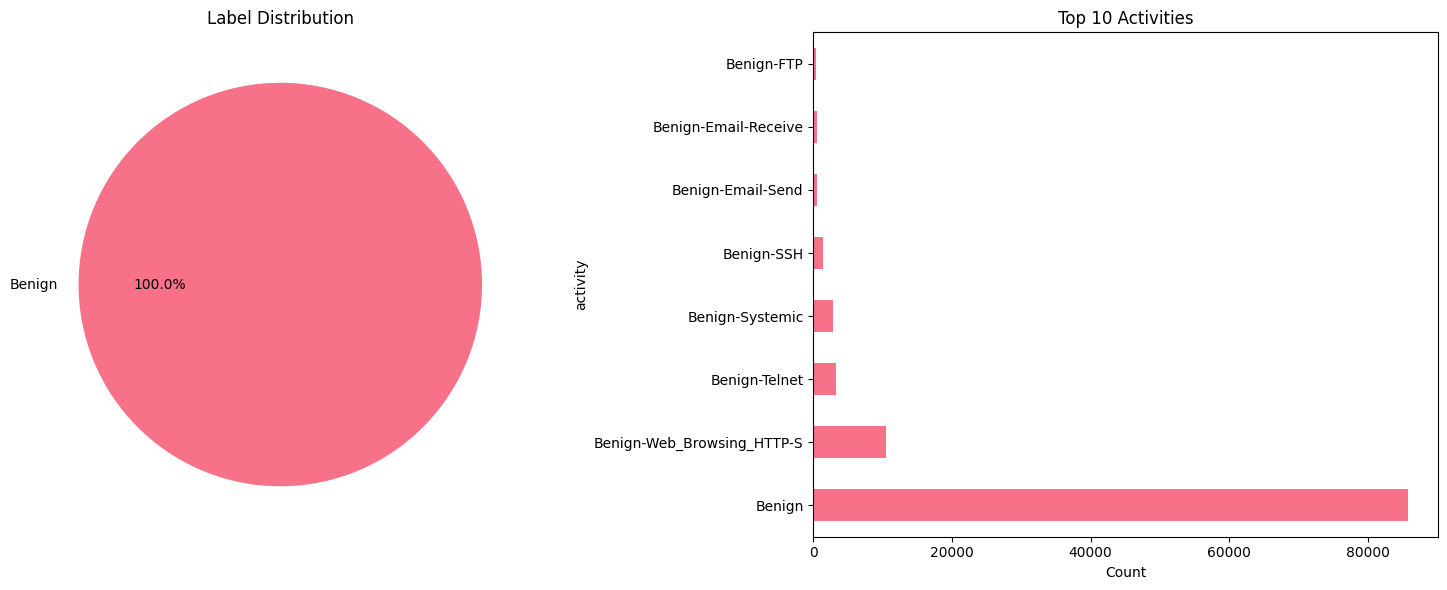


⏰ TIME SERIES ANALYSIS
📅 Total duration: 0 days 07:59:36.457007
⚡ Average time between flows: 0 days 00:00:00.273837209
🏃 Minimum time gap: 0 days 00:00:00
🐌 Maximum time gap: 0 days 00:00:09.125841

📈 Temporal Patterns Analysis:
🔍 Peak traffic hour: 15:00 (15,188 flows)


ValueError: attempt to get argmax of an empty sequence

In [ ]:
# Example usage:

# Load your dataset
df = data

# Initialize EDA
eda = NetworkFlowEDA(df)

# Run complete analysis
eda.run_complete_eda()

# Or run individual analyses
eda.time_series_analysis()
eda.prepare_sequential_windows(window_size=200, step_size=100)


### tuesday

In [ ]:
data = pd.read_csv(root+'/Tuesday_19_Dec_2023.csv')


🔄 Initializing dataset preprocessing...
✅ Dataset initialized: 85,479 rows, 14 columns
🚀 STARTING COMPREHENSIVE EDA FOR SEQUENTIAL MODELING
📊 DATASET OVERVIEW
📏 Shape: 85,479 rows × 14 columns
💾 Memory usage: 41.81 MB
🔄 Duplicate rows: 126
⏰ Time range: 2023-12-19 08:59:11.233748 to 2023-12-19 17:00:03.446487
📅 Duration: 0 days 08:00:52.212739

✅ No missing values found

🏷️ LABEL AND ACTIVITY ANALYSIS
📊 Label Distribution:
   Benign: 49,990 (58.48%)
   Suspicious: 27,296 (31.93%)
   Attack: 8,193 (9.58%)

🎯 Activity Distribution (14 unique activities):
   Benign: 28,678 (33.55%)
   Suspicious: 27,296 (31.93%)
   Benign-Systemic: 13,337 (15.60%)
   Benign-Web_Browsing_HTTP-S: 7,084 (8.29%)
   Attack-TCP-Flag-SYN-TFO: 3,631 (4.25%)
   Attack-TCP-Flag-RST-ACK: 1,445 (1.69%)
   Attack-TCP-Flag-SYN-TIME: 1,360 (1.59%)
   Attack-TCP-Flag-OSYNP: 890 (1.04%)
   Attack-TCP-Flag-OSYN: 867 (1.01%)
   Benign-Email-Send: 342 (0.40%)
   ... and 4 more activities


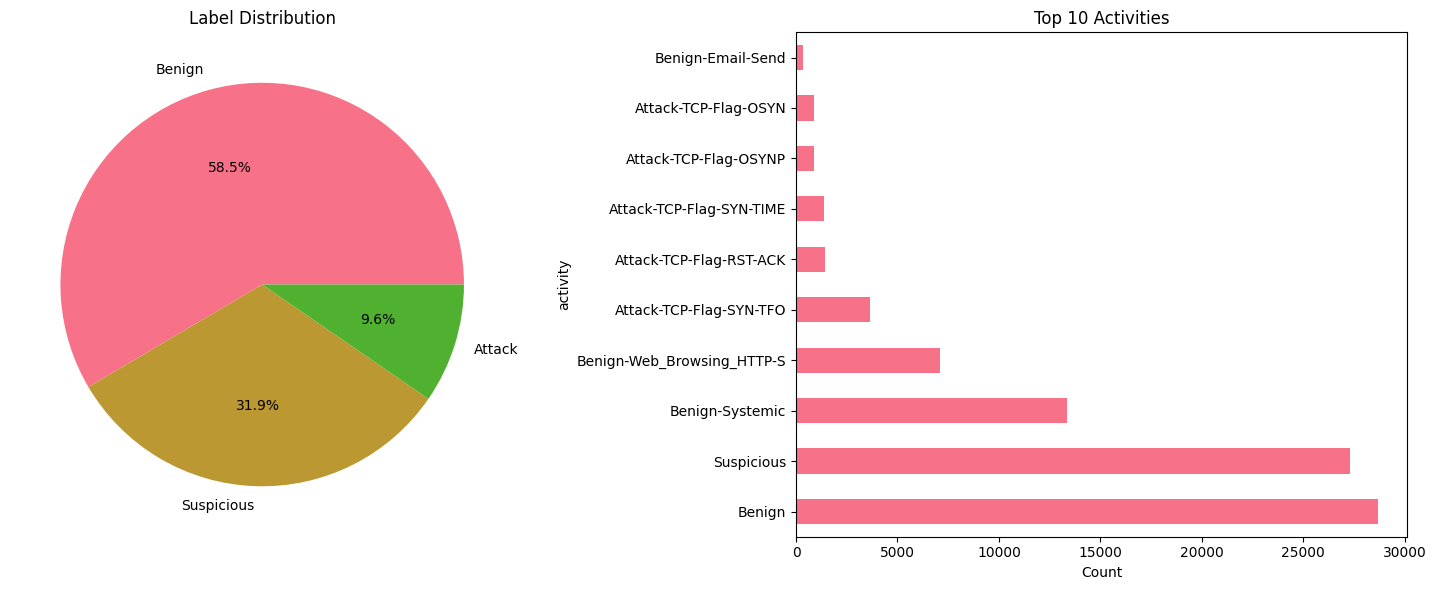


⏰ TIME SERIES ANALYSIS
📅 Total duration: 0 days 08:00:52.212739
⚡ Average time between flows: 0 days 00:00:00.337539632
🏃 Minimum time gap: 0 days 00:00:00
🐌 Maximum time gap: 0 days 00:00:10.532003

📈 Temporal Patterns Analysis:
🔍 Peak traffic hour: 15:00 (16,903 flows)
🎯 Peak attack hour: 9:00 (5,076 attacks)
⚠️ Highest attack ratio: 9:00 (53.06%)


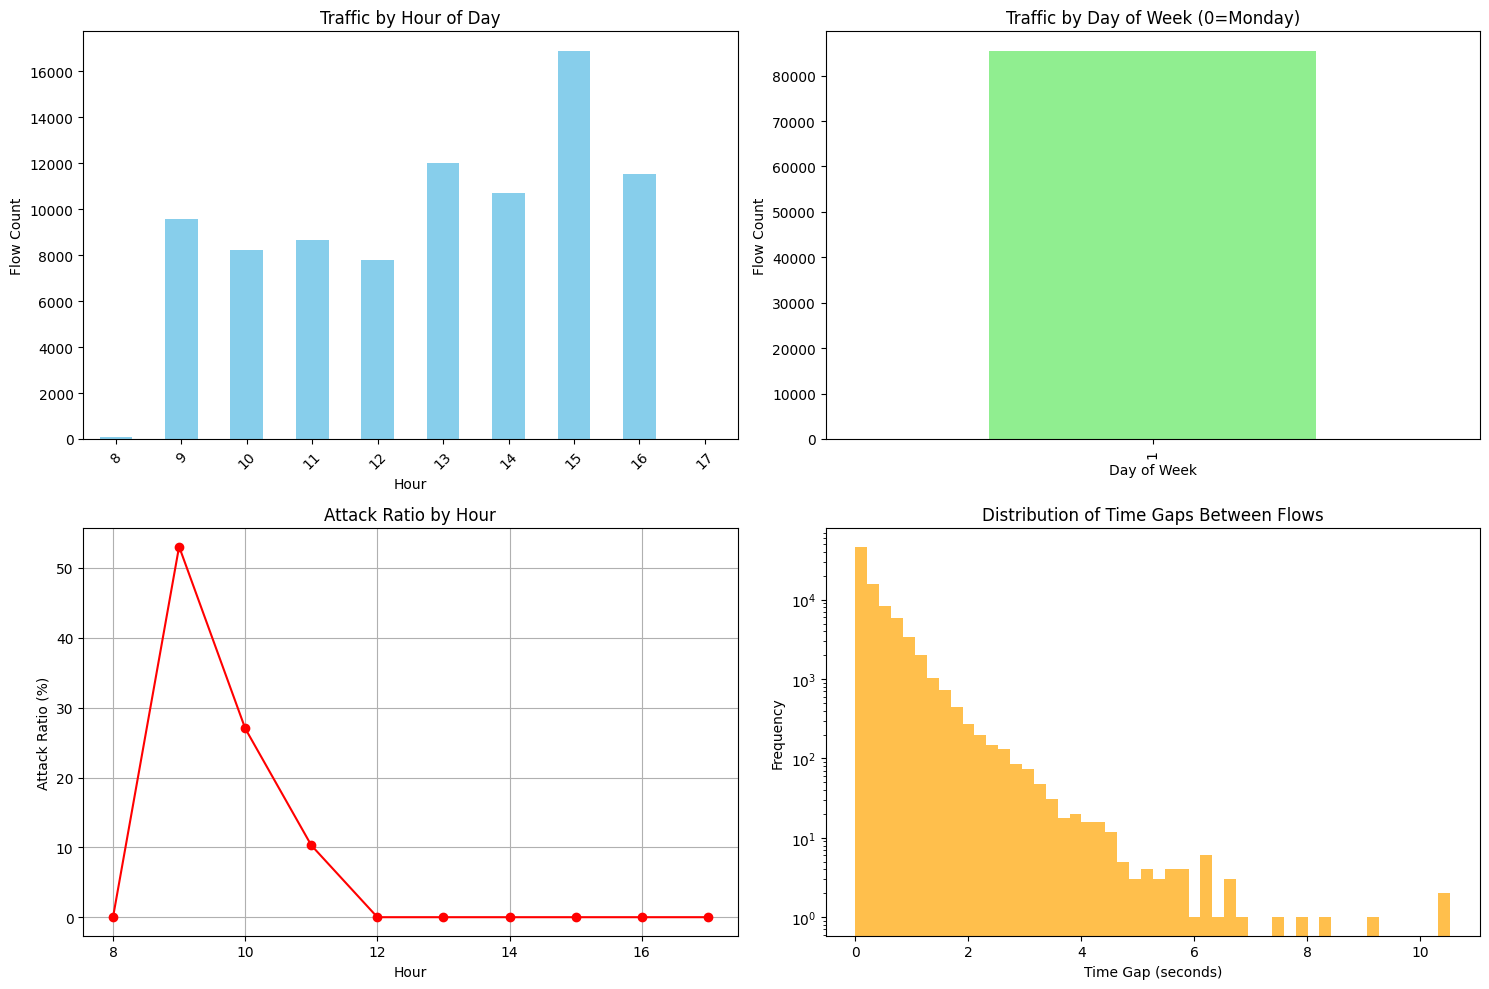


🚨 Attack Patterns Over Time:
📊 1-minute windows with attacks: 150
📊 5-minute windows with attacks: 30
🔥 Max attacks in 1-minute window: 290
🔥 Max attacks in 5-minute window: 824


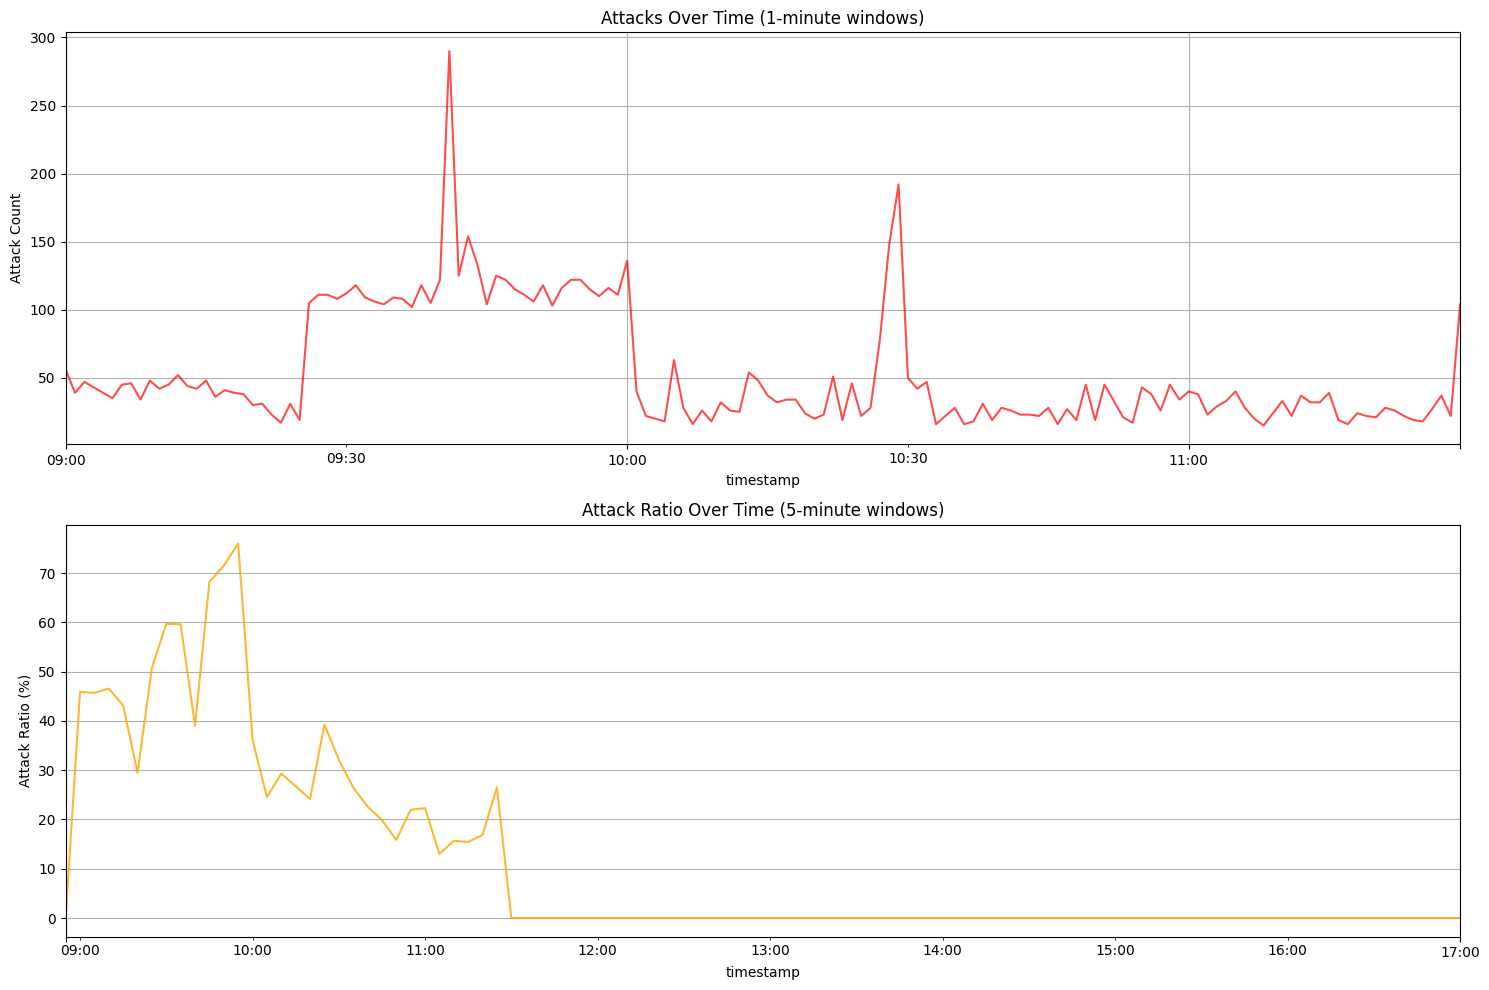


🔗 Sequential Characteristics Analysis:
🔄 Most common label transitions:
   Benign → Benign: 33,857
   Suspicious → Suspicious: 15,023
   Suspicious → Benign: 12,272
   Benign → Suspicious: 12,271
   Attack → Attack: 4,331
   Benign → Attack: 3,861
   Attack → Benign: 3,861
   Suspicious → Attack: 1
   Attack → Suspicious: 1

⚡ Attack sequence analysis:
   Total attack sequences: 3,862
   Average sequence length: 2.12
   Longest attack sequence: 83
   Sequences longer than 10: 45

⏱️ Time gap statistics (for window sizing):
   Mean gap: 0.34 seconds
   Median gap: 0.17 seconds
   95th percentile: 1.15 seconds
   99th percentile: 2.09 seconds

🌐 NETWORK FEATURES ANALYSIS
📡 Protocol Distribution:
   TCP: 85,479 (100.00%)

🔌 Port Analysis:

   Top 10 src ports:
      443: 1,955
      48546: 1,032
      51685: 980
      53252: 951
      50594: 874
      48509: 690
      40872: 432
      45424: 404
      45414: 395
      45440: 383
   Well-known ports (src_port): 10 unique
   High ports (sr

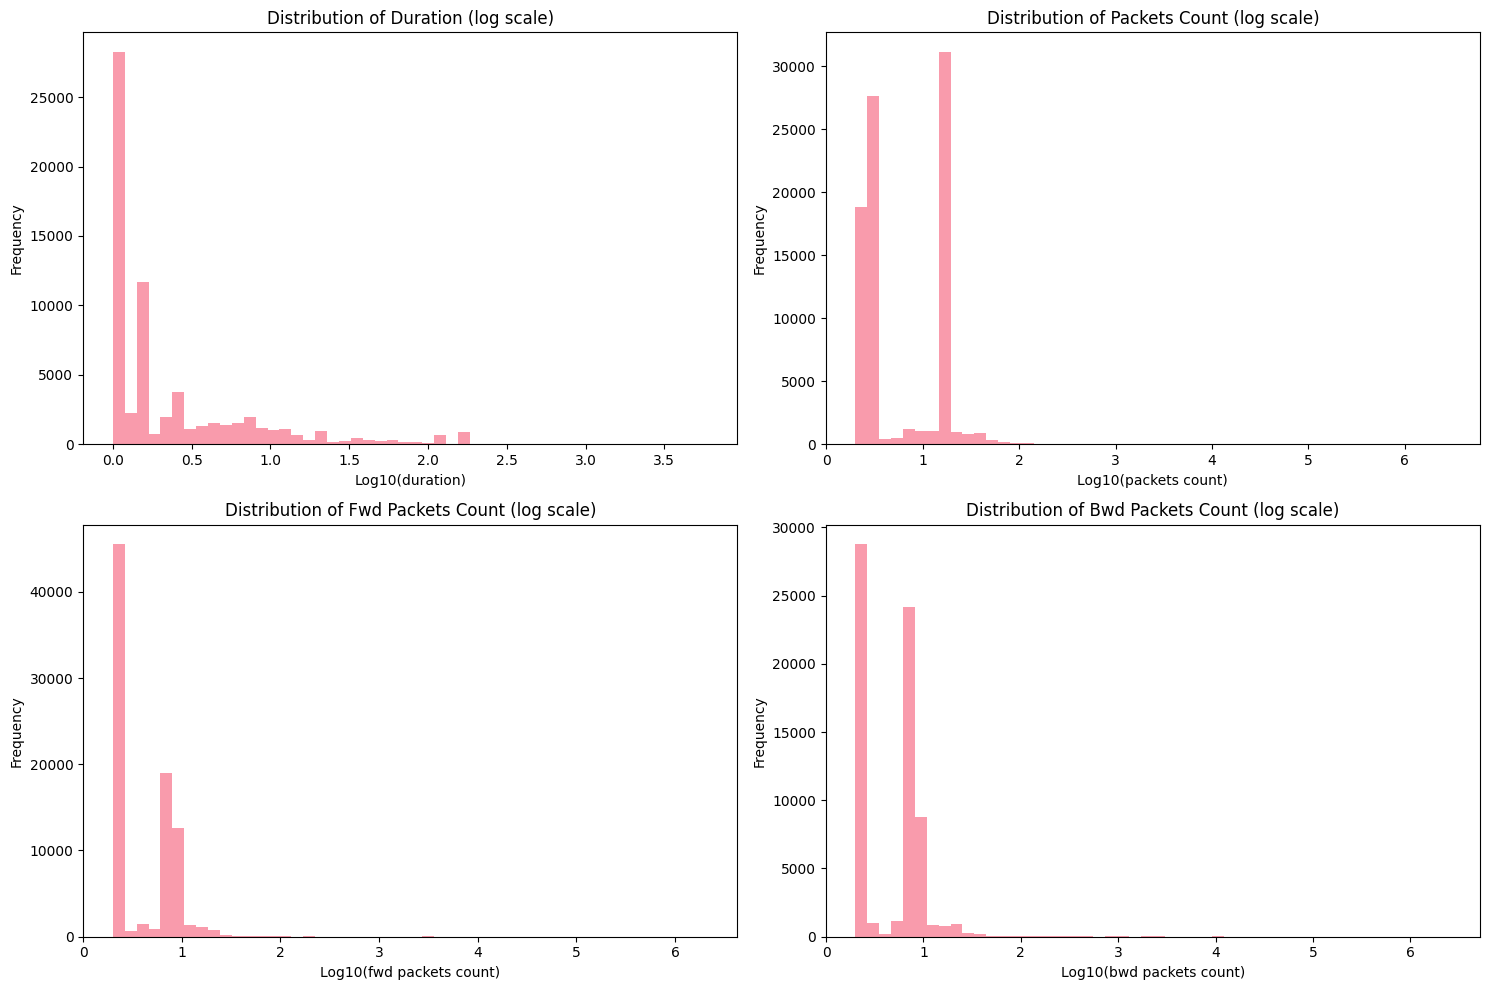


🔗 CORRELATION ANALYSIS
🔍 Highly correlated feature pairs (|correlation| > 0.7):
   bwd_packets_count ↔ packets_count: 0.947


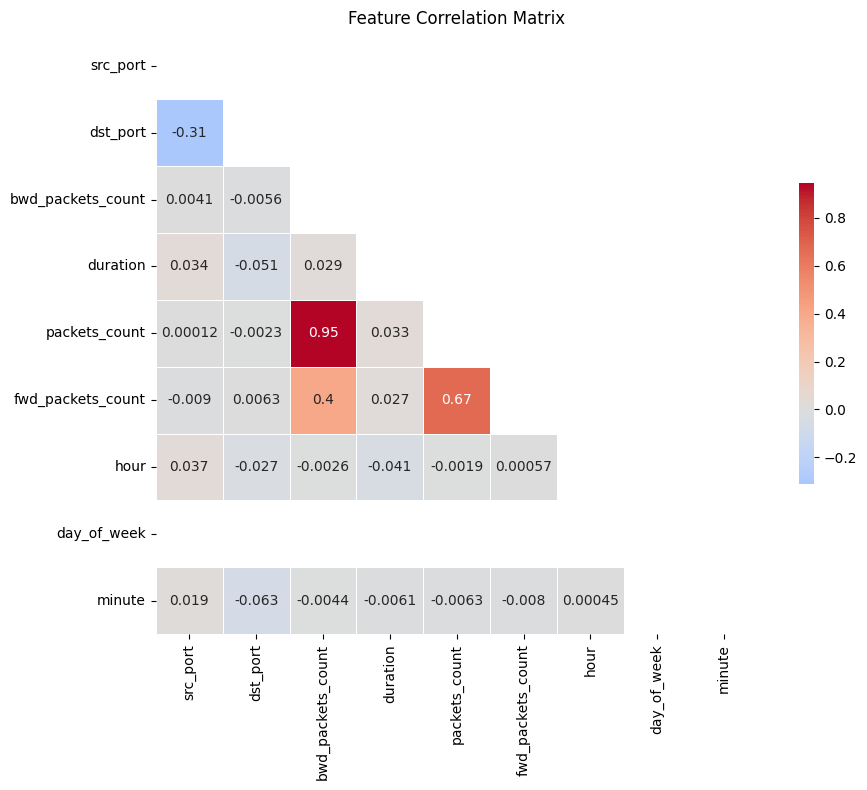


🪟 PREPARING SEQUENTIAL WINDOWS
Window size: 100, Step size: 50
✅ Created 1,708 windows
📊 Overlap ratio: 0.50
⏱️ Average time span per window: 33.42 seconds

🏷️ Window label distribution:
   Benign: 1,120 windows (65.57%)
   Suspicious: 456 windows (26.70%)
   Attack: 132 windows (7.73%)

💡 RECOMMENDATIONS FOR SEQUENTIAL MODELING:
📏 Current window covers ~33 seconds on average
⚡ Average time between flows: 0.34 seconds
🎯 Recommended window sizes:
   For 1-minute windows: ~177 flows
   For 5-minute windows: ~885 flows
⚠️ Moderate class imbalance (ratio: 0.118)

📋 NETWORK FLOW EDA REPORT
Generated on: 2025-09-30 08:31:01
Dataset shape: 85,479 rows × 17 columns
Time range: 0 days 08:00:52.212739

Label distribution:
  Benign: 49,990 (58.48%)
  Suspicious: 27,296 (31.93%)
  Attack: 8,193 (9.58%)

Sequential characteristics:
  Mean time gap: 0.34s
  Median time gap: 0.17s
  Attack sequences found: 3862
  Average sequence length: 2.12
✅ EDA COMPLETE! Ready for sequential modeling.

⏰ TIME SE

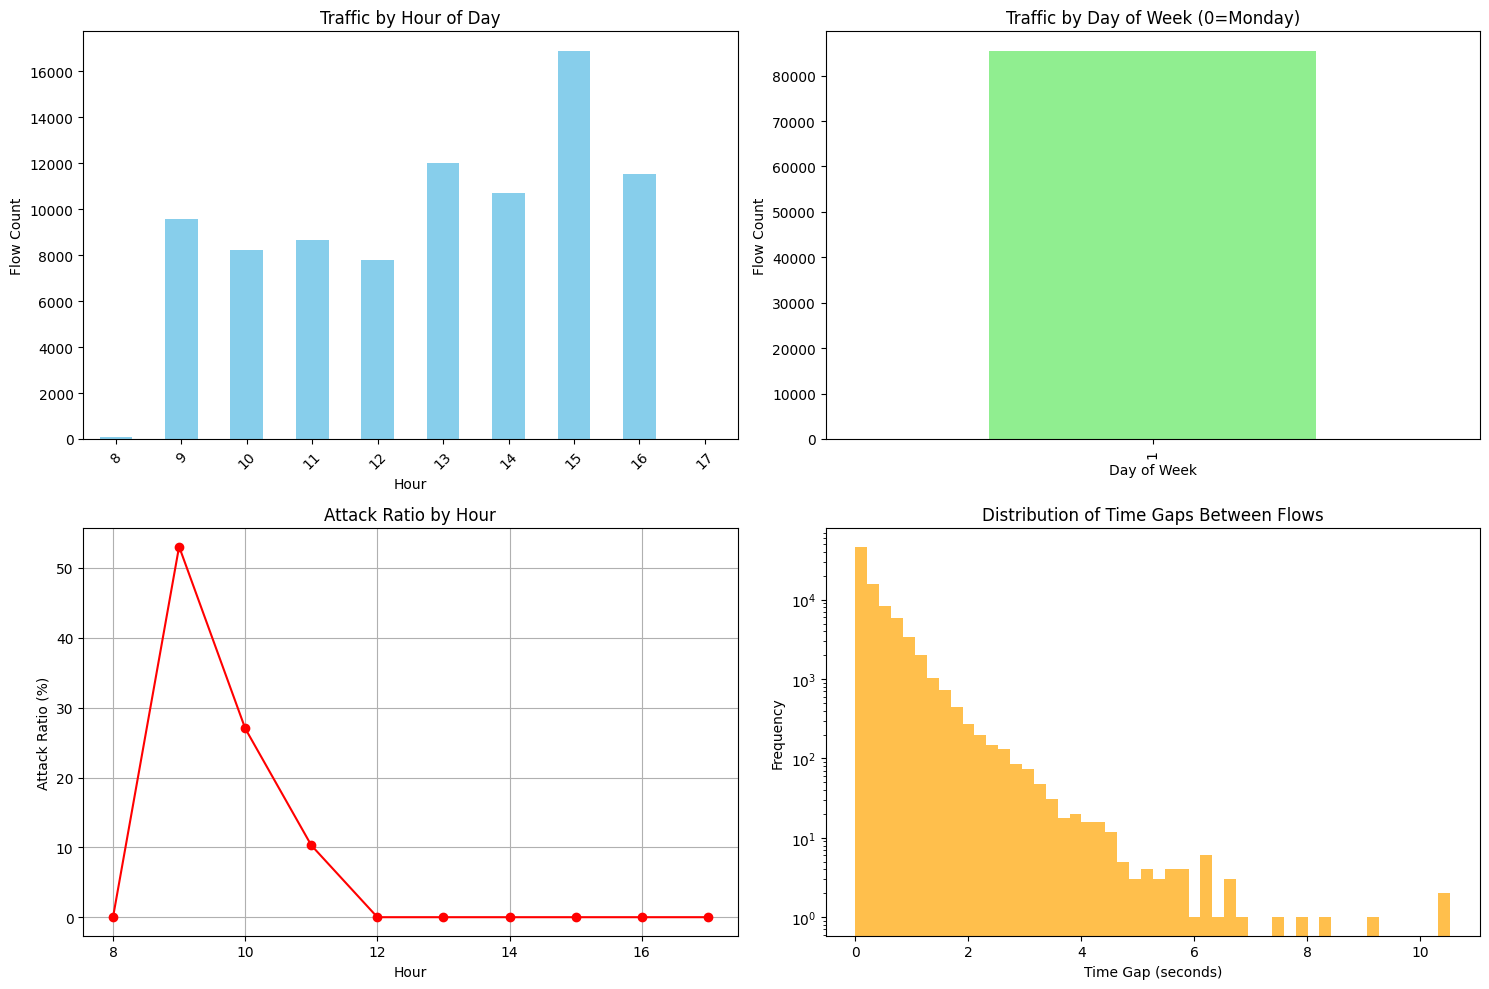


🚨 Attack Patterns Over Time:
📊 1-minute windows with attacks: 150
📊 5-minute windows with attacks: 30
🔥 Max attacks in 1-minute window: 290
🔥 Max attacks in 5-minute window: 824


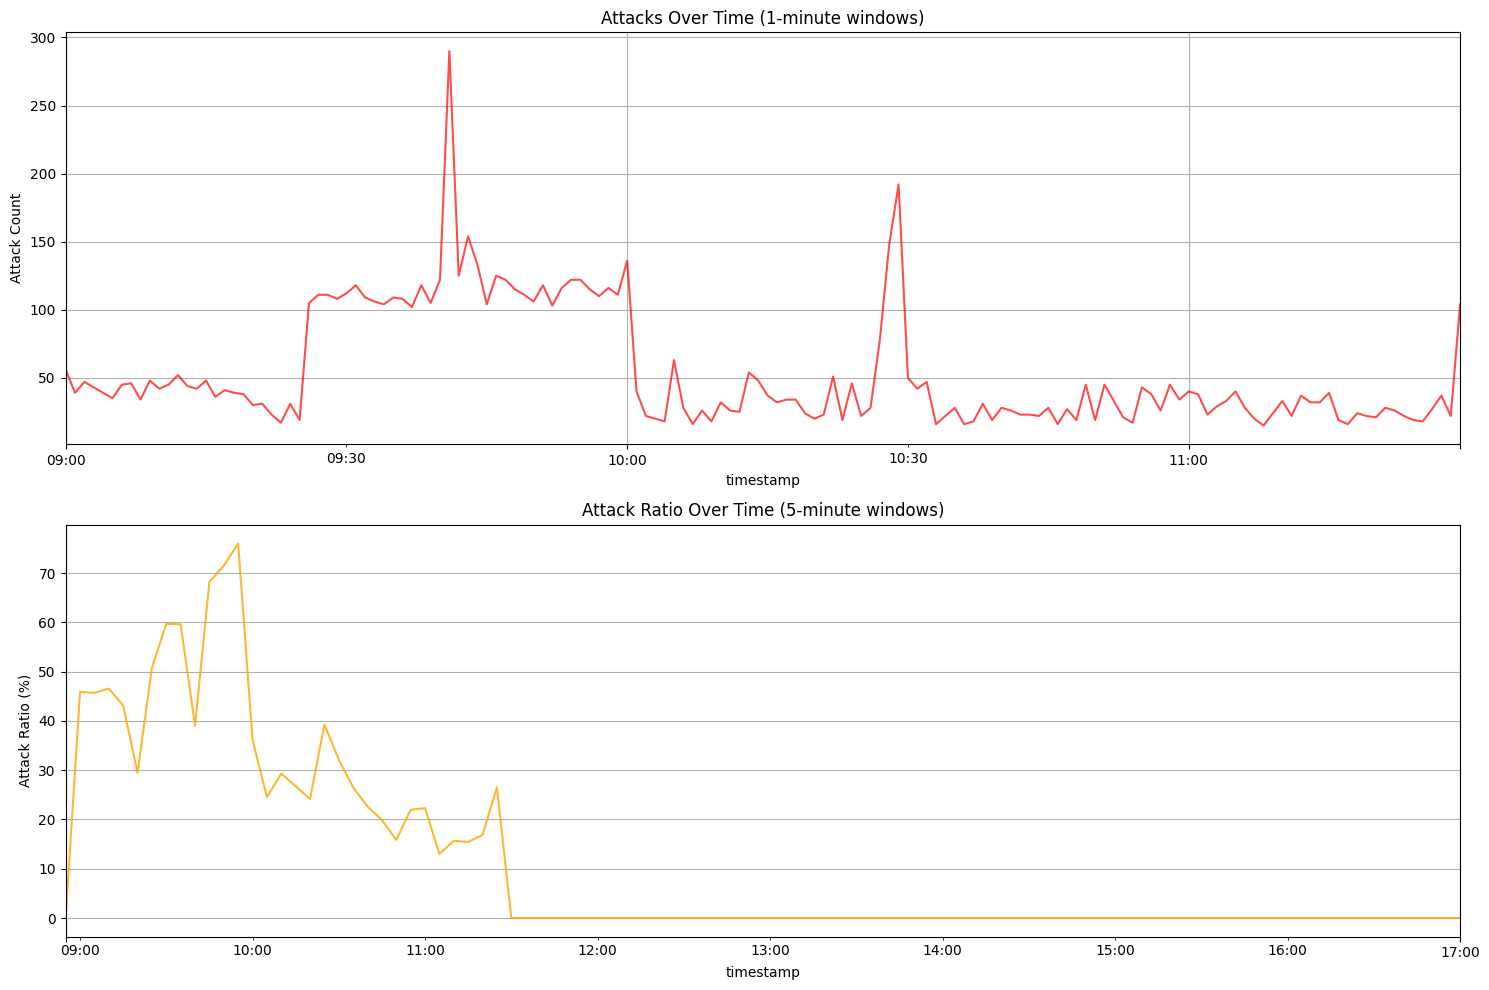


🔗 Sequential Characteristics Analysis:
🔄 Most common label transitions:
   Benign → Benign: 33,857
   Suspicious → Suspicious: 15,023
   Suspicious → Benign: 12,272
   Benign → Suspicious: 12,271
   Attack → Attack: 4,331
   Benign → Attack: 3,861
   Attack → Benign: 3,861
   Suspicious → Attack: 1
   Attack → Suspicious: 1

⚡ Attack sequence analysis:
   Total attack sequences: 3,862
   Average sequence length: 2.12
   Longest attack sequence: 83
   Sequences longer than 10: 45

⏱️ Time gap statistics (for window sizing):
   Mean gap: 0.34 seconds
   Median gap: 0.17 seconds
   95th percentile: 1.15 seconds
   99th percentile: 2.09 seconds

🪟 PREPARING SEQUENTIAL WINDOWS
Window size: 200, Step size: 100
✅ Created 853 windows
📊 Overlap ratio: 0.50
⏱️ Average time span per window: 67.17 seconds

🏷️ Window label distribution:
   Benign: 567 windows (66.47%)
   Suspicious: 226 windows (26.49%)
   Attack: 60 windows (7.03%)

💡 RECOMMENDATIONS FOR SEQUENTIAL MODELING:
📏 Current window cove

{'total_windows': 853,
 'window_size': 200,
 'step_size': 100,
 'overlap_ratio': 0.5,
 'time_span_per_window': [98.577816,
  108.845746,
  130.884331,
  144.900722,
  142.306458,
  127.958697,
  125.567977,
  135.025714,
  130.935286,
  118.151452,
  126.449003,
  129.70694,
  123.836278,
  120.55823,
  118.749704,
  130.436543,
  131.133678,
  122.578415,
  132.255592,
  138.067726,
  133.449956,
  134.393355,
  126.22886,
  111.650976,
  101.347971,
  81.735024,
  64.441377,
  57.745705,
  53.946606,
  60.175921,
  63.940734,
  60.637245,
  58.446319,
  61.757456,
  62.892186,
  60.54344,
  63.374277,
  65.658451,
  71.413988,
  68.3579,
  62.549846,
  63.896855,
  64.221341,
  67.639084,
  67.448773,
  63.921639,
  66.747042,
  64.100307,
  61.615692,
  69.199603,
  55.297362,
  32.014002,
  42.878715,
  52.849085,
  23.16353,
  3.200189,
  3.658013,
  3.448425,
  3.637453,
  4.801474,
  9.329453,
  16.470262,
  27.389712,
  40.363965,
  52.516779,
  48.466838,
  27.821296,
  28.470

In [ ]:
# Example usage:

# Load your dataset
df = data

# Initialize EDA
eda = NetworkFlowEDA(df)

# Run complete analysis
eda.run_complete_eda()

# Or run individual analyses
eda.time_series_analysis()
eda.prepare_sequential_windows(window_size=200, step_size=100)


# preprocess

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import psutil
import time
import gc
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

class TimeBasedDDoSPipeline:
    def __init__(self, data):
        self.data = data.copy()
        self.start_time = None
        self.memory_tracker = {}
        self.performance_stats = {}

    def track_performance(self, step_name, start_time):
        """Track time and memory for each step"""
        end_time = time.time()
        elapsed = end_time - start_time

        # Memory usage
        process = psutil.Process()
        memory_mb = process.memory_info().rss / (1024 * 1024)

        self.performance_stats[step_name] = {
            'duration_seconds': elapsed,
            'memory_mb': memory_mb,
            'timestamp': datetime.now()
        }

        print(f"✅ {step_name}: {elapsed:.2f}s | Memory: {memory_mb:.1f}MB")
        return end_time

    def load_and_clean_monday_data(self):
        """Step 1: Load Monday data with smart duplicate removal"""

        print("STEP 1: LOADING & CLEANING MONDAY DATA")
        print("="*50)
        step_start = time.time()

        # Use pre-loaded data
        print("Using pre-loaded Monday_18_Dec_2023 data...")
        df = self.data.copy()

        print(f"Original dataset: {len(df):,} rows, {df.shape[1]} columns")
        print(f"Memory usage: {df.memory_usage(deep=True).sum() / (1024**2):.1f} MB")

        # Check data quality
        print(f"\nData quality check:")
        print(f"Duplicates found: {df.duplicated().sum():,}")
        print(f"Missing values: {df.isnull().sum().sum()}")

        # Smart duplicate removal: only if same flow_id
        print(f"\nRemoving duplicates based on flow_id...")
        before_dedup = len(df)

        if 'flow_id' in df.columns:
            # Remove duplicates only where flow_id is identical
            df = df.drop_duplicates(subset=['flow_id'], keep='first')
            flow_id_dups = before_dedup - len(df)
            print(f"Removed {flow_id_dups:,} flow_id duplicates")
        else:
            print("No flow_id column found, skipping flow_id deduplication")

        # Handle missing values
        print(f"\nHandling missing values...")
        missing_before = df.isnull().sum().sum()

        if missing_before > 0:
            # Drop rows with missing timestamps (critical)
            if 'timestamp' in df.columns and df['timestamp'].isnull().sum() > 0:
                timestamp_nulls = df['timestamp'].isnull().sum()
                df = df.dropna(subset=['timestamp'])
                print(f"Dropped {timestamp_nulls:,} rows with missing timestamps")

            # Fill other missing values
            numeric_cols = ['duration', 'packets_count', 'fwd_packets_count', 'bwd_packets_count']
            for col in numeric_cols:
                if col in df.columns and df[col].isnull().sum() > 0:
                    nulls_filled = df[col].isnull().sum()
                    df[col] = df[col].fillna(0)
                    print(f"Filled {nulls_filled:,} missing values in {col}")

        # Convert timestamp and sort
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.sort_values('timestamp').reset_index(drop=True)

        # Data validation
        print(f"\nFinal cleaned dataset:")
        print(f"Rows: {len(df):,}")
        print(f"Columns: {df.shape[1]}")
        print(f"Time range: {df['timestamp'].min()} to {df['timestamp'].max()}")
        print(f"Duration: {df['timestamp'].max() - df['timestamp'].min()}")

        # Label distribution
        if 'label' in df.columns:
            label_dist = df['label'].value_counts()
            print(f"\nLabel distribution:")
            for label, count in label_dist.items():
                print(f"  {label}: {count:,} ({count/len(df)*100:.2f}%)")

        self.track_performance("Data Loading & Cleaning", step_start)
        return df

    def analyze_time_based_windowing_parameters(self, df):
        """Step 2: Analyze parameters for time-based windowing"""

        print(f"\nSTEP 2: ANALYZING TIME-BASED WINDOWING PARAMETERS")
        print("="*50)
        step_start = time.time()

        # Time range analysis
        start_time = df['timestamp'].min()
        end_time = df['timestamp'].max()
        total_duration = (end_time - start_time).total_seconds()

        print(f"Time range analysis:")
        print(f"  Start time: {start_time}")
        print(f"  End time: {end_time}")
        print(f"  Total duration: {total_duration:.1f} seconds ({total_duration/3600:.2f} hours)")

        # Window configuration for time-based windowing
        window_config = {
            'window_duration_seconds': 2.0,  # Fixed 2-second windows
            'step_duration_seconds': 1.0,    # 1-second steps (50% overlap)
            'start_time': start_time,
            'end_time': end_time,
            'total_duration': total_duration,
            'min_flows_per_window': 1  # Allow windows with at least 1 flow
        }

        # Estimate number of windows
        estimated_windows = int(total_duration / window_config['step_duration_seconds'])

        print(f"\nTime-Based Window Configuration:")
        print(f"  Window duration: {window_config['window_duration_seconds']} seconds (FIXED)")
        print(f"  Step duration: {window_config['step_duration_seconds']} seconds")
        print(f"  Overlap: 50%")
        print(f"  Estimated total windows: {estimated_windows:,}")

        # Flow distribution analysis
        flows_per_second = len(df) / total_duration
        expected_flows_per_window = flows_per_second * window_config['window_duration_seconds']

        print(f"\nFlow distribution analysis:")
        print(f"  Average flows per second: {flows_per_second:.2f}")
        print(f"  Expected flows per 2-second window: {expected_flows_per_window:.1f}")
        print(f"  Actual flow distribution will vary with network activity")

        # Memory estimation
        features_per_window = 45  # Same number of features
        estimated_memory_mb = (estimated_windows * features_per_window * 8) / (1024**2)

        print(f"\nMemory estimates:")
        print(f"  Features per window: {features_per_window}")
        print(f"  Estimated memory for features: {estimated_memory_mb:.1f} MB")
        print(f"  Estimated processing time: {estimated_windows / 1000:.1f} minutes")

        self.track_performance("Time-Based Windowing Analysis", step_start)
        return window_config

    def create_time_based_windows_with_features(self, df, config):
        """Step 3: Create time-based windows with feature engineering"""

        print(f"\nSTEP 3: CREATING TIME-BASED WINDOWS WITH FEATURE ENGINEERING")
        print("="*50)
        step_start = time.time()

        windows = []
        labels = []
        regression_labels = []
        timestamps = []
        flow_counts = []

        window_duration = pd.Timedelta(seconds=config['window_duration_seconds'])
        step_duration = pd.Timedelta(seconds=config['step_duration_seconds'])

        # Create time-based windows
        current_start = config['start_time']
        window_count = 0
        windows_created = 0
        windows_skipped = 0

        # Progress tracking
        total_duration = config['total_duration']
        progress_interval = max(100, int(total_duration / config['step_duration_seconds']) // 20)

        print(f"Processing time-based windows...")
        print(f"Window duration: {config['window_duration_seconds']} seconds (FIXED)")
        print(f"Step size: {config['step_duration_seconds']} seconds")

        # Memory monitoring
        initial_memory = psutil.Process().memory_info().rss / (1024**2)

        while current_start + window_duration <= config['end_time']:
            current_end = current_start + window_duration

            # Extract flows within this time window
            mask = (df['timestamp'] >= current_start) & (df['timestamp'] < current_end)
            window_data = df[mask].copy()

            # Skip empty windows or windows with too few flows
            if len(window_data) < config['min_flows_per_window']:
                current_start += step_duration
                windows_skipped += 1
                window_count += 1
                continue

            try:
                # Engineer features for this time window
                actual_duration = config['window_duration_seconds']  # Always exactly 2.0 seconds
                features = self.engineer_time_window_features(window_data, actual_duration)
                windows.append(features)

                # Determine window label
                window_label = self.determine_window_label(window_data)
                window_regression_label = self.determine_window_regression_label(window_data)
                labels.append(window_label)
                regression_labels.append(window_regression_label)

                timestamps.append(current_start)
                flow_counts.append(len(window_data))

                windows_created += 1

                # Progress reporting
                if windows_created % progress_interval == 0:
                    current_memory = psutil.Process().memory_info().rss / (1024**2)
                    memory_increase = current_memory - initial_memory
                    progress_pct = ((current_start - config['start_time']).total_seconds() / total_duration) * 100
                    avg_flows = np.mean(flow_counts[-progress_interval:]) if flow_counts else 0

                    print(f"  Progress: {windows_created:,} windows ({progress_pct:.1f}%) | "
                          f"Memory: +{memory_increase:.1f}MB | "
                          f"Avg flows per window: {avg_flows:.1f}")

            except Exception as e:
                print(f"  Error processing window at {current_start}: {e}")
                windows_skipped += 1

            # Move to next window
            current_start += step_duration
            window_count += 1

        # Final statistics
        print(f"\nTime-Based Windowing Results:")
        print(f"  Windows created: {windows_created:,}")
        print(f"  Windows skipped: {windows_skipped:,} (empty windows)")
        print(f"  Success rate: {windows_created/(windows_created+windows_skipped)*100:.1f}%")
        print(f"  All windows have EXACTLY {config['window_duration_seconds']} second duration")

        if flow_counts:
            flow_stats = {
                'mean': np.mean(flow_counts),
                'median': np.median(flow_counts),
                'min': np.min(flow_counts),
                'max': np.max(flow_counts),
                'std': np.std(flow_counts)
            }

            print(f"\nFlows per window statistics:")
            for stat, value in flow_stats.items():
                print(f"  {stat}: {value:.1f}")

        # Label distribution
        if labels:
            unique_labels, counts = np.unique(labels, return_counts=True)
            label_names = {0: 'Benign', 1: 'Attack'}

            print(f"\nWindow label distribution:")
            for label_idx, count in zip(unique_labels, counts):
                name = label_names.get(label_idx, f'Unknown_{label_idx}')
                print(f"  {name}: {count:,} ({count/len(labels)*100:.2f}%)")

        self.track_performance("Time-Based Window Creation & Feature Engineering", step_start)
        return windows, labels, regression_labels, timestamps, flow_counts
        #return windows, labels, timestamps, flow_counts

    def engineer_time_window_features(self, window_data, window_duration):
        """Comprehensive feature engineering for time-based windows"""

        total_flows = len(window_data)

        if total_flows == 0:
            return self.get_empty_features()

        # Basic aggregations
        total_packets = window_data['packets_count'].sum()
        total_fwd_packets = window_data['fwd_packets_count'].sum()
        total_bwd_packets = window_data['bwd_packets_count'].sum()

        features = {
            # === RATE FEATURES (Now truly meaningful with fixed time) ===
            'flow_rate': total_flows / window_duration,  # Flows per second
            'packet_rate': total_packets / window_duration,  # Packets per second
            'fwd_packet_rate': total_fwd_packets / window_duration,
            'bwd_packet_rate': total_bwd_packets / window_duration,

            # === VOLUME FEATURES ===
            'total_flows': total_flows,
            'total_packets': total_packets,
            'total_fwd_packets': total_fwd_packets,
            'total_bwd_packets': total_bwd_packets,
            'avg_packets_per_flow': window_data['packets_count'].mean(),
            'max_packets_per_flow': window_data['packets_count'].max(),
            'min_packets_per_flow': window_data['packets_count'].min(),

            # === CONNECTION DIVERSITY ===
            'unique_src_ips': window_data['src_ip'].nunique(),
            'unique_dst_ips': window_data['dst_ip'].nunique(),
            'unique_src_ports': window_data['src_port'].nunique(),
            'unique_dst_ports': window_data['dst_port'].nunique(),
            'src_ip_diversity_ratio': window_data['src_ip'].nunique() / total_flows,
            'dst_ip_concentration_ratio': total_flows / max(window_data['dst_ip'].nunique(), 1),

            # === PORT TARGETING PATTERNS ===
            'rdp_targeting_ratio': (window_data['dst_port'] == 3389).sum() / total_flows,
            'smb_targeting_ratio': (window_data['dst_port'] == 445).sum() / total_flows,
            'http_targeting_ratio': (window_data['dst_port'] == 80).sum() / total_flows,
            'https_targeting_ratio': (window_data['dst_port'] == 443).sum() / total_flows,
            'well_known_ports_ratio': (window_data['dst_port'] <= 1023).sum() / total_flows,
            'most_targeted_port_ratio': window_data['dst_port'].value_counts().iloc[0] / total_flows,

            # === DIRECTIONAL FLOW PATTERNS ===
            'fwd_bwd_packet_ratio': total_fwd_packets / max(total_bwd_packets, 1),
            'fwd_packet_percentage': total_fwd_packets / max(total_packets, 1),
            'zero_bwd_flows_ratio': (window_data['bwd_packets_count'] == 0).sum() / total_flows,
            'zero_fwd_flows_ratio': (window_data['fwd_packets_count'] == 0).sum() / total_flows,
            'unidirectional_flows_ratio': ((window_data['bwd_packets_count'] == 0) |
                                         (window_data['fwd_packets_count'] == 0)).sum() / total_flows,

            # === TEMPORAL CHARACTERISTICS (Now more meaningful) ===
            'window_duration': window_duration,  # Always exactly 2.0
            'avg_flow_duration': window_data['duration'].mean(),
            'max_flow_duration': window_data['duration'].max(),
            'duration_std': window_data['duration'].std(),
            'short_flows_ratio': (window_data['duration'] < 1.0).sum() / total_flows,
            'zero_duration_ratio': (window_data['duration'] == 0).sum() / total_flows,

            # === STATISTICAL FEATURES ===
            'packet_count_variance': window_data['packets_count'].var(),
            'packet_count_skewness': window_data['packets_count'].skew(),
            'duration_variance': window_data['duration'].var(),
            'fwd_packet_variance': window_data['fwd_packets_count'].var(),
            'bwd_packet_variance': window_data['bwd_packets_count'].var(),

            # === ATTACK INDICATORS ===
            'high_volume_flows_ratio': (window_data['packets_count'] > 1000).sum() / total_flows,
            'burst_flows_ratio': (window_data['packets_count'] > window_data['packets_count'].quantile(0.95)).sum() / total_flows,
            'potential_flooding_indicator': (window_data['packets_count'] < 5).sum() / total_flows,

            # === DENSITY FEATURES (New - meaningful with fixed time) ===
            'flow_density': total_flows,  # Number of flows in this 2-second window
            'connection_intensity': window_data['src_ip'].nunique() * window_data['dst_ip'].nunique(),

            # === ENTROPY MEASURES ===
            'src_port_entropy': self.calculate_entropy(window_data['src_port']),
            'dst_port_entropy': self.calculate_entropy(window_data['dst_port']),
            'packet_size_entropy': self.calculate_entropy(window_data['packets_count']),
        }

        return features

    def calculate_entropy(self, series):
        """Calculate Shannon entropy for a series"""
        if len(series) == 0:
            return 0.0

        value_counts = series.value_counts()
        probabilities = value_counts / len(series)
        entropy = -np.sum(probabilities * np.log2(probabilities + 1e-10))
        return float(entropy)

    def get_empty_features(self):
        """Return zero-filled features for empty windows"""
        feature_names = [
            'flow_rate', 'packet_rate', 'fwd_packet_rate', 'bwd_packet_rate',
            'total_flows', 'total_packets', 'total_fwd_packets', 'total_bwd_packets',
            'avg_packets_per_flow', 'max_packets_per_flow', 'min_packets_per_flow',
            'unique_src_ips', 'unique_dst_ips', 'unique_src_ports', 'unique_dst_ports',
            'src_ip_diversity_ratio', 'dst_ip_concentration_ratio',
            'rdp_targeting_ratio', 'smb_targeting_ratio', 'http_targeting_ratio',
            'https_targeting_ratio', 'well_known_ports_ratio', 'most_targeted_port_ratio',
            'fwd_bwd_packet_ratio', 'fwd_packet_percentage', 'zero_bwd_flows_ratio',
            'zero_fwd_flows_ratio', 'unidirectional_flows_ratio',
            'window_duration', 'avg_flow_duration', 'max_flow_duration', 'duration_std',
            'short_flows_ratio', 'zero_duration_ratio',
            'packet_count_variance', 'packet_count_skewness', 'duration_variance',
            'fwd_packet_variance', 'bwd_packet_variance',
            'high_volume_flows_ratio', 'burst_flows_ratio', 'potential_flooding_indicator',
            'flow_density', 'connection_intensity',
            'src_port_entropy', 'dst_port_entropy', 'packet_size_entropy'
        ]
        return {name: 0.0 for name in feature_names}

    def determine_window_label(self, window_data):
        """Determine window label based on flow labels"""

        '''if 'label' not in window_data.columns:
            return 0  # Default to benign

        label_counts = window_data['label'].value_counts()
        total_flows = len(window_data)

        # Attack priority: >5% attack flows
        if 'Attack' in label_counts.index:
            attack_ratio = label_counts['Attack'] / total_flows
            if attack_ratio == 0:
              return 0
            if attack_ratio > 0.1:
                return 1  # Attack
            if attack_ratio <= 0.1:
              return 2

        # Suspicious priority: >20% suspicious flows
        if 'Suspicious' in label_counts.index:
            suspicious_ratio = label_counts['Suspicious'] / total_flows
            if suspicious_ratio > 0.2:
                return 1  # Suspicious'''
        # if window contain attack then label 1 else 0
        if 'Attack' in window_data['label'].unique():
            return 1  # Attack

        return 0  # Benign'''

    def determine_window_regression_label(self, window_data):
        """Determine regression label based on flow labels"""
        if 'label' not in window_data.columns:
            return 0  # Default to benign

        label_counts = window_data['label'].value_counts()
        total_flows = len(window_data)
        if 'Attack' in label_counts.index:
            attack_ratio = label_counts['Attack'] / total_flows
            return attack_ratio

    def prepare_feature_matrix(self, windows, labels, regression_labels):
    #def prepare_feature_matrix(self, windows, labels):

        """Step 4: Prepare normalized feature matrix"""

        print(f"\nSTEP 4: PREPARING FEATURE MATRIX")
        print("="*50)
        step_start = time.time()

        if not windows:
            raise ValueError("No windows created - cannot prepare feature matrix")

        # Convert to DataFrame
        print("Converting to DataFrame...")
        feature_df = pd.DataFrame(windows)

        print(f"Feature matrix shape: {feature_df.shape}")
        print(f"Features: {len(feature_df.columns)}")

        # Handle missing values
        missing_count = feature_df.isnull().sum().sum()
        if missing_count > 0:
            print(f"Filling {missing_count:,} missing values with 0")
            feature_df = feature_df.fillna(0)

        # Handle infinite values
        inf_count = np.isinf(feature_df.values).sum()
        if inf_count > 0:
            print(f"Replacing {inf_count:,} infinite values")
            feature_df = feature_df.replace([np.inf, -np.inf], 0)

        # Normalize features
        print("Normalizing features...")
        scaler = StandardScaler()
        features_normalized = scaler.fit_transform(feature_df)

        # Convert labels to numpy array
        y = np.array(labels)
        y2 = np.array(regression_labels)

        print(f"\nFeature Matrix Info:")
        print(f"  Shape: {features_normalized.shape}")
        print(f"  Memory usage: {features_normalized.nbytes / (1024**2):.1f} MB")
        print(f"  Data type: {features_normalized.dtype}")

        # Feature statistics
        print(f"\nFeature Statistics:")
        print(f"  Mean range: [{features_normalized.mean(axis=0).min():.3f}, {features_normalized.mean(axis=0).max():.3f}]")
        print(f"  Std range: [{features_normalized.std(axis=0).min():.3f}, {features_normalized.std(axis=0).max():.3f}]")

        # Label distribution
        unique_labels, counts = np.unique(y, return_counts=True)
        label_names = {0: 'Benign', 1: 'Suspicious', 2: 'Attack'}

        print(f"\nFinal Label Distribution:")
        for label_idx, count in zip(unique_labels, counts):
            name = label_names.get(label_idx, f'Unknown_{label_idx}')
            print(f"  {name}: {count:,} ({count/len(y)*100:.2f}%)")

        self.track_performance("Feature Matrix Preparation", step_start)
        return features_normalized, y, y2, scaler, feature_df.columns.tolist()
        #return features_normalized, y, scaler, feature_df.columns.tolist()


    def generate_performance_report(self):
        """Generate comprehensive performance report"""

        print(f"\n" + "="*70)
        print("COMPREHENSIVE PERFORMANCE REPORT")
        print("="*70)

        total_time = sum([stats['duration_seconds'] for stats in self.performance_stats.values()])
        peak_memory = max([stats['memory_mb'] for stats in self.performance_stats.values()])

        print(f"Overall Performance:")
        print(f"  Total processing time: {total_time:.2f} seconds ({total_time/60:.1f} minutes)")
        print(f"  Peak memory usage: {peak_memory:.1f} MB")

        print(f"\nStep-by-step breakdown:")
        for step, stats in self.performance_stats.items():
            print(f"  {step:.<40} {stats['duration_seconds']:>8.2f}s | {stats['memory_mb']:>8.1f}MB")

        # Memory efficiency analysis
        current_process = psutil.Process()
        current_memory = current_process.memory_info().rss / (1024**2)

        print(f"\nMemory Analysis:")
        print(f"  Current memory usage: {current_memory:.1f} MB")
        print(f"  Memory efficiency: {(peak_memory - current_memory) / peak_memory * 100:.1f}% temporary usage")

        return {
            'total_time_seconds': total_time,
            'peak_memory_mb': peak_memory,
            'current_memory_mb': current_memory,
            'step_details': self.performance_stats
        }

# Complete execution function
def run_time_based_pipeline(data):
    """Execute the complete time-based Monday pipeline"""

    pipeline = TimeBasedDDoSPipeline(data)

    print("TIME-BASED DDOS DETECTION PIPELINE")
    print("="*70)
    print(f"Processing pre-loaded data with {len(data):,} rows")
    print(f"Using FIXED 2-second time windows")
    print(f"Start time: {datetime.now()}")

    try:
        # Step 1: Load and clean
        clean_data = pipeline.load_and_clean_monday_data()

        # Step 2: Analyze time-based windowing
        window_config = pipeline.analyze_time_based_windowing_parameters(clean_data)

        # Step 3: Create time-based windows with features
        windows, labels, regression_labels, timestamps, flow_counts = pipeline.create_time_based_windows_with_features(
            clean_data, window_config)
        '''windows, labels, timestamps, flow_counts = pipeline.create_time_based_windows_with_features(
            clean_data, window_config)'''

        # Step 4: Prepare feature matrix
        X, y, y2, scaler, feature_names = pipeline.prepare_feature_matrix(windows, labels, regression_labels)
        #X, y, scaler, feature_names = pipeline.prepare_feature_matrix(windows, labels)

        # Step 5: Generate performance report
        performance_report = pipeline.generate_performance_report()

        # Final summary
        print(f"\n" + "="*70)
        print("TIME-BASED PIPELINE COMPLETED SUCCESSFULLY!")
        print("="*70)
        print(f"Final Dataset:")
        print(f"  Windows created: {len(X):,}")
        print(f"  Features per window: {len(feature_names)}")
        print(f"  Feature matrix shape: {X.shape}")
        print(f"  Labels shape: {y.shape}")
        print(f"  ALL windows are EXACTLY 2.0 seconds duration")
        print(f"  Ready for model training: YES")

        return {
            'X': X,
            'y': y,
            'scaler': scaler,
            'feature_names': feature_names,
            'window_config': window_config,
            'timestamps': timestamps,
            'flow_counts': flow_counts,  # Variable flow counts per window
            'performance_report': performance_report,
            'raw_data': clean_data
        }

    except Exception as e:
        print(f"Pipeline failed: {e}")
        import traceback
        traceback.print_exc()
        return None



In [ ]:
monday_data = pd.read_csv(root + "/Monday_18_Dec_2023.csv")
tuesday_data = pd.read_csv(root + "/Tuesday_19_Dec_2023.csv")
thursday_data = pd.read_csv(root + "/Thursday_14_Dec_2023.csv")

### monday

In [ ]:
monday_results = run_time_based_pipeline(monday_data)
print("Monday results stored ✓")

TIME-BASED DDOS DETECTION PIPELINE
Processing pre-loaded data with 320,530 rows
Using FIXED 2-second time windows
Start time: 2025-09-30 08:31:42.241383
STEP 1: LOADING & CLEANING MONDAY DATA
Using pre-loaded Monday_18_Dec_2023 data...
Original dataset: 320,530 rows, 13 columns
Memory usage: 163.0 MB

Data quality check:
Duplicates found: 72
Missing values: 2

Removing duplicates based on flow_id...
Removed 187 flow_id duplicates

Handling missing values...
Dropped 2 rows with missing timestamps

Final cleaned dataset:
Rows: 320,341
Columns: 13
Time range: 2023-12-18 08:56:39.178993 to 2023-12-18 17:00:11.846422
Duration: 0 days 08:03:32.667429

Label distribution:
  Attack: 220,251 (68.76%)
  Benign: 68,292 (21.32%)
  Suspicious: 31,798 (9.93%)
✅ Data Loading & Cleaning: 2.34s | Memory: 1202.7MB

STEP 2: ANALYZING TIME-BASED WINDOWING PARAMETERS
Time range analysis:
  Start time: 2023-12-18 08:56:39.178993
  End time: 2023-12-18 17:00:11.846422
  Total duration: 29012.7 seconds (8.06 

### thursday

In [ ]:
thursday_results = run_time_based_pipeline(thursday_data)
print("Thursday results stored ✓")

TIME-BASED DDOS DETECTION PIPELINE
Processing pre-loaded data with 105,087 rows
Using FIXED 2-second time windows
Start time: 2025-09-30 08:35:19.822000
STEP 1: LOADING & CLEANING MONDAY DATA
Using pre-loaded Monday_18_Dec_2023 data...
Original dataset: 105,087 rows, 13 columns
Memory usage: 52.4 MB

Data quality check:
Duplicates found: 36
Missing values: 0

Removing duplicates based on flow_id...
Removed 98 flow_id duplicates

Handling missing values...

Final cleaned dataset:
Rows: 104,989
Columns: 13
Time range: 2023-12-14 09:01:00.856447 to 2023-12-14 17:00:37.313454
Duration: 0 days 07:59:36.457007

Label distribution:
  Benign: 104,989 (100.00%)
✅ Data Loading & Cleaning: 0.40s | Memory: 1225.1MB

STEP 2: ANALYZING TIME-BASED WINDOWING PARAMETERS
Time range analysis:
  Start time: 2023-12-14 09:01:00.856447
  End time: 2023-12-14 17:00:37.313454
  Total duration: 28776.5 seconds (7.99 hours)

Time-Based Window Configuration:
  Window duration: 2.0 seconds (FIXED)
  Step duration

### tuesday

In [ ]:
tuesday_results = run_time_based_pipeline(tuesday_data)
print("Tuesday results stored ✓")

TIME-BASED DDOS DETECTION PIPELINE
Processing pre-loaded data with 85,479 rows
Using FIXED 2-second time windows
Start time: 2025-09-30 08:38:13.416667
STEP 1: LOADING & CLEANING MONDAY DATA
Using pre-loaded Monday_18_Dec_2023 data...
Original dataset: 85,479 rows, 13 columns
Memory usage: 43.0 MB

Data quality check:
Duplicates found: 126
Missing values: 0

Removing duplicates based on flow_id...
Removed 258 flow_id duplicates

Handling missing values...

Final cleaned dataset:
Rows: 85,221
Columns: 13
Time range: 2023-12-19 08:59:11.233748 to 2023-12-19 17:00:03.446487
Duration: 0 days 08:00:52.212739

Label distribution:
  Benign: 49,813 (58.45%)
  Suspicious: 27,246 (31.97%)
  Attack: 8,162 (9.58%)
✅ Data Loading & Cleaning: 0.34s | Memory: 1225.5MB

STEP 2: ANALYZING TIME-BASED WINDOWING PARAMETERS
Time range analysis:
  Start time: 2023-12-19 08:59:11.233748
  End time: 2023-12-19 17:00:03.446487
  Total duration: 28852.2 seconds (8.01 hours)

Time-Based Window Configuration:
  W

# MODEL

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, mean_absolute_error, confusion_matrix
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

class DDoSMultiTaskLSTM(nn.Module):
    """
    Multi-task LSTM model for DDoS detection - PyTorch Version
    - Classification: Binary attack/no-attack prediction
    - Regression: Attack intensity/percentage prediction
    - DYNAMIC FEATURE SIZE: Automatically adapts to any number of input features
    """

    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super(DDoSMultiTaskLSTM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        print(f"🧠 Model initialized with {input_size} features (AUTO-DETECTED)")

        # Shared LSTM backbone
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Shared feature extraction
        self.shared_fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # Classification head (binary: attack/no-attack)
        self.classifier = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

        # Regression head (attack intensity 0-1)
        self.regressor = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(16, 1),
            nn.Sigmoid()  # Ensures output between 0-1
        )

    def forward(self, x):
        """
        Forward pass
        Args:
            x: (batch_size, sequence_length, input_size)
        Returns:
            classification_output: (batch_size, 1) - probability of attack
            regression_output: (batch_size, 1) - attack intensity [0-1]
        """
        batch_size = x.size(0)

        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        # LSTM forward pass
        lstm_out, (hn, cn) = self.lstm(x, (h0, c0))

        # Use the last time step output
        last_output = lstm_out[:, -1, :]  # (batch_size, hidden_size)

        # Shared feature extraction
        shared_features = self.shared_fc(last_output)

        # Task-specific heads
        classification_output = self.classifier(shared_features)
        regression_output = self.regressor(shared_features)

        return classification_output, regression_output

class MultiTaskLoss(nn.Module):
    """
    Combined loss for multi-task learning
    """
    def __init__(self, alpha=1.0, beta=0.3):
        super(MultiTaskLoss, self).__init__()
        self.alpha = alpha  # Weight for classification loss
        self.beta = beta   # Weight for regression loss

        self.bce_loss = nn.BCELoss()
        self.mse_loss = nn.MSELoss()

    def forward(self, class_pred, class_target, reg_pred, reg_target):
        """
        Combined loss calculation
        """

        # Extract samples where target is class 0
        class_0_mask = (class_target == 0)
        class_0_pred = class_pred[class_0_mask]
        class_0_target = class_target[class_0_mask]

        # Extract samples where target is class 1
        class_1_mask = (class_target == 1)
        class_1_pred = class_pred[class_1_mask]
        class_1_target = class_target[class_1_mask]

        classification_loss = self.bce_loss(class_pred, class_target)
        regression_loss = self.mse_loss(reg_pred, reg_target)

        reg_loss = self.alpha * self.bce_loss(class_1_pred, class_1_target) + self.beta * self.mse_loss(reg_pred[class_1_mask], reg_target[class_1_mask])
        class_loss = self.bce_loss(class_0_pred, class_0_target)
        # (y)* reg_loss + (1-y) * class_loss
        total_loss = reg_loss + class_loss

        return total_loss, classification_loss, regression_loss

class DDoSSequenceDataset(Dataset):
    """
    Dataset class for DDoS detection sequences with OVERLAPPING support
    """
    def __init__(self, sequences, classification_labels, regression_labels):
        self.sequences = torch.FloatTensor(sequences)
        self.classification_labels = torch.FloatTensor(classification_labels).unsqueeze(1)
        self.regression_labels = torch.FloatTensor(regression_labels).unsqueeze(1)

        print(f"📊 Dataset created:")
        print(f"   - Sequences shape: {self.sequences.shape}")
        print(f"   - Features per window: {self.sequences.shape[2]}")
        print(f"   - Sequence length: {self.sequences.shape[1]}")
        print(f"   - Total sequences: {len(self.sequences)}")

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return (self.sequences[idx],
                self.classification_labels[idx],
                self.regression_labels[idx])

class MultiOutputLSTMPipeline:
    """
    🔄 MODIFIED: Complete PyTorch Pipeline for Multi-Output LSTM DDoS Detection
    WITH STRATIFIED SPLIT + COMBINED TRAINING + THURSDAY TESTING
    """
    def __init__(self, sequence_length=50):
        self.models = {}
        self.sequence_length = sequence_length
        # 🚀 CHANGE 1: Force GPU usage
        self.device = torch.device('cuda')
        self.training_history = {}
        self.threshold_results = {}  # Store threshold testing results

        print(f"🚀 Modified Pipeline initialized:")
        print(f"   - Device: {self.device}")
        print(f"   - Sequence length: {sequence_length} windows")
        print(f"   - Overlapping: YES (sliding window)")
        print(f"   - Features: AUTO-DETECT from data")
        print(f"   - Splitting: STRATIFIED (maintains class balance)")
        print(f"   - Training: COMBINED days (Monday + Tuesday)")
        print(f"   - Testing: Thursday for false positive rate")

    def create_realistic_regression_labels(self, results):
        """Create realistic regression labels from raw data"""
        print("🏷️  Creating regression labels from raw data...")

        raw_data = results['raw_data']
        timestamps = results['timestamps']
        y_regression = []

        # For each window, calculate actual attack percentage
        for i, window_timestamp in enumerate(timestamps):
            # Find corresponding window in raw data (approximately)
            window_start = window_timestamp
            window_end = window_start + pd.Timedelta(seconds=2)

            # Get flows in this window
            mask = (raw_data['timestamp'] >= window_start) & (raw_data['timestamp'] < window_end)
            window_flows = raw_data[mask]

            if len(window_flows) > 0:
                # Calculate percentage of attack flows
                if 'Attack' in window_flows['label'].values:
                    attack_count = (window_flows['label'] == 'Attack').sum()
                    total_count = len(window_flows)
                    attack_percentage = attack_count / total_count
                else:
                    attack_percentage = 0.0
            else:
                attack_percentage = 0.0

            y_regression.append(attack_percentage)

        results['y2'] = np.array(y_regression)

        # Statistics
        attack_windows = (results['y'] == 1).sum()
        regression_stats = {
            'min': np.min(results['y2']),
            'max': np.max(results['y2']),
            'mean': np.mean(results['y2']),
            'std': np.std(results['y2'])
        }

        print(f"✅ Regression labels created:")
        print(f"   - Total windows: {len(results['y2']):,}")
        print(f"   - Attack windows: {attack_windows:,}")
        print(f"   - Regression range: [{regression_stats['min']:.3f}, {regression_stats['max']:.3f}]")
        print(f"   - Mean intensity: {regression_stats['mean']:.3f}")

        return results

    def combine_datasets(self, monday_results, tuesday_results):
        """🆕 NEW: Combine Monday and Tuesday datasets"""
        print(f"\n🔄 COMBINING MONDAY + TUESDAY DATASETS:")
        print("="*50)

        # Create regression labels for both
        monday_results = self.create_realistic_regression_labels(monday_results)
        tuesday_results = self.create_realistic_regression_labels(tuesday_results)

        # Check feature consistency
        monday_features = monday_results['X'].shape[1]
        tuesday_features = tuesday_results['X'].shape[1]

        if monday_features != tuesday_features:
            print(f"⚠️ Feature mismatch: Monday={monday_features}, Tuesday={tuesday_features}")
            print("Using minimum feature count for compatibility")
            min_features = min(monday_features, tuesday_features)
            monday_X = monday_results['X'][:, :min_features]
            tuesday_X = tuesday_results['X'][:, :min_features]
        else:
            monday_X = monday_results['X']
            tuesday_X = tuesday_results['X']
            print(f"✅ Feature consistency: Both have {monday_features} features")

        # Combine all data
        combined_X = np.vstack([monday_X, tuesday_X])
        combined_y = np.concatenate([monday_results['y'], tuesday_results['y']])
        combined_y2 = np.concatenate([monday_results['y2'], tuesday_results['y2']])
        combined_timestamps = monday_results['timestamps'] + tuesday_results['timestamps']

        print(f"📊 Combined Dataset Statistics:")
        print(f"   - Total windows: {len(combined_X):,}")
        print(f"   - Features: {combined_X.shape[1]}")
        print(f"   - Monday contribution: {len(monday_results['X']):,} windows")
        print(f"   - Tuesday contribution: {len(tuesday_results['X']):,} windows")

        # Class distribution
        unique_classes, counts = np.unique(combined_y, return_counts=True)
        print(f"   - Benign windows: {counts[0]:,} ({counts[0]/len(combined_y)*100:.1f}%)")
        if len(counts) > 1:
            print(f"   - Attack windows: {counts[1]:,} ({counts[1]/len(combined_y)*100:.1f}%)")

        return {
            'X': combined_X,
            'y': combined_y,
            'y2': combined_y2,
            'timestamps': combined_timestamps,
            'feature_count': combined_X.shape[1]
        }

    def create_overlapping_sequences(self, X, y_binary, y_regression, timestamps):
        """
        Create OVERLAPPING sequences using sliding window approach
        🔄 OVERLAPPING = Each sequence starts 1 window after the previous one
        """
        sequences = []
        binary_labels = []
        regression_labels = []

        print(f"🔄 Creating OVERLAPPING sequences:")
        print(f"   - Input windows: {len(X):,}")
        print(f"   - Sequence length: {self.sequence_length}")
        print(f"   - Window size: 2 seconds")
        print(f"   - Total time per sequence: {self.sequence_length * 2} seconds")
        print(f"   - Features per window: {X.shape[1]}")

        # OVERLAPPING sliding window approach
        for i in range(len(X) - self.sequence_length + 1):
            # Create sequence of length 'sequence_length'
            sequence = X[i:i + self.sequence_length]

            # Label is from the LAST window in the sequence
            binary_label = y_binary[i + self.sequence_length - 1]
            regression_label = y_regression[i + self.sequence_length - 1]

            sequences.append(sequence)
            binary_labels.append(binary_label)
            regression_labels.append(regression_label)

        sequences = np.array(sequences)
        binary_labels = np.array(binary_labels)
        regression_labels = np.array(regression_labels)

        print(f"✅ OVERLAPPING sequences created:")
        print(f"   - Total sequences: {len(sequences):,}")
        print(f"   - Overlap factor: {len(sequences) / (len(X) / self.sequence_length):.1f}x more data!")
        print(f"   - Sequences shape: {sequences.shape}")
        print(f"   - Binary distribution: Attack={np.sum(binary_labels):,}, Benign={np.sum(1-binary_labels):,}")
        print(f"   - Regression range: [{regression_labels.min():.3f}, {regression_labels.max():.3f}]")

        return sequences, binary_labels, regression_labels

    def split_data_stratified(self, X_seq, y_binary, y_regression, train_ratio=0.7, val_ratio=0.15):
        """🆕 NEW: Stratified split to maintain class balance"""
        print(f"📊 STRATIFIED DATA SPLITTING:")
        print("="*50)

        n_samples = len(X_seq)

        # First split: train vs (val + test)
        X_train, X_temp, y_bin_train, y_bin_temp, y_reg_train, y_reg_temp = train_test_split(
            X_seq, y_binary, y_regression,
            test_size=(1 - train_ratio),
            stratify=y_binary,
            random_state=42
        )

        # Second split: val vs test
        val_size_rel = val_ratio / (val_ratio + (1 - train_ratio - val_ratio))
        X_val, X_test, y_bin_val, y_bin_test, y_reg_val, y_reg_test = train_test_split(
            X_temp, y_bin_temp, y_reg_temp,
            test_size=(1 - val_size_rel),
            stratify=y_bin_temp,
            random_state=42
        )

        # Report split statistics
        splits = [
            ("Train", len(X_train), y_bin_train),
            ("Val", len(X_val), y_bin_val),
            ("Test", len(X_test), y_bin_test)
        ]

        for name, size, labels in splits:
            unique, counts = np.unique(labels, return_counts=True)
            benign = counts[0] if len(counts) > 0 else 0
            attack = counts[1] if len(counts) > 1 else 0
            print(f"   {name}: {size:,} samples ({size/n_samples*100:.1f}%) - "
                  f"Benign: {benign:,}, Attack: {attack:,}")

        return X_train, X_val, X_test, y_bin_train, y_bin_val, y_bin_test, y_reg_train, y_reg_val, y_reg_test

    def train_combined_model(self, monday_results, tuesday_results):
        """🆕 NEW: Train model on combined Monday + Tuesday data with stratified split"""
        print(f"\n{'='*80}")
        print(f"🎯 TRAINING COMBINED MODEL (MONDAY + TUESDAY) - STRATIFIED SPLIT")
        print(f"{'='*80}")

        # Combine datasets
        combined_data = self.combine_datasets(monday_results, tuesday_results)

        # Skip if no attacks
        if (combined_data['y'] == 0).all():
            print(f"❌ Combined data has no attacks - cannot train")
            return None

        # Auto-detect number of features
        num_features = combined_data['feature_count']
        print(f"🔍 AUTO-DETECTED {num_features} features in combined data")

        # Create OVERLAPPING sequences
        X_seq, y_binary, y_regression = self.create_overlapping_sequences(
            combined_data['X'], combined_data['y'], combined_data['y2'],
            combined_data['timestamps']
        )

        # Check if we have both classes
        unique_classes = np.unique(y_binary)
        if len(unique_classes) < 2:
            print(f"❌ Warning: Only one class present: {unique_classes}")
            return None

        print(f"✅ Both classes present: {unique_classes}")

        # STRATIFIED split (maintains class balance)
        X_train, X_val, X_test, y_bin_train, y_bin_val, y_bin_test, y_reg_train, y_reg_val, y_reg_test = self.split_data_stratified(
            X_seq, y_binary, y_regression
        )

        # Create datasets with overlapping sequences
        train_dataset = DDoSSequenceDataset(X_train, y_bin_train, y_reg_train)
        val_dataset = DDoSSequenceDataset(X_val, y_bin_val, y_reg_val)
        test_dataset = DDoSSequenceDataset(X_test, y_bin_test, y_reg_test)

        # Create dataloaders
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        # Build model with AUTO-DETECTED feature size
        model = DDoSMultiTaskLSTM(input_size=num_features).to(self.device)

        # Count parameters
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"🧠 Model parameters: {trainable_params:,} trainable, {total_params:,} total")

        # Loss and optimizer
        criterion = MultiTaskLoss(alpha=1.0, beta=0.3)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

        # Training loop with FULL MONITORING
        print(f"🚀 Starting PyTorch training on COMBINED data with STRATIFIED split...")
        model.train()
        num_epochs = 50
        best_val_loss = float('inf')
        patience = 20
        patience_counter = 0

        # Store training history
        history = {
            'train_loss': [], 'val_loss': [], 'test_loss': [],
            'train_class_loss': [], 'val_class_loss': [], 'test_class_loss': [],
            'train_reg_loss': [], 'val_reg_loss': [], 'test_reg_loss': []
        }

        for epoch in range(num_epochs):
            # ================== TRAINING ==================
            model.train()
            train_total_loss = train_class_loss = train_reg_loss = 0.0

            for batch_sequences, batch_class_labels, batch_reg_labels in train_loader:
                batch_sequences = batch_sequences.to(self.device)
                batch_class_labels = batch_class_labels.to(self.device)
                batch_reg_labels = batch_reg_labels.to(self.device)

                optimizer.zero_grad()

                # Forward pass
                class_pred, reg_pred = model(batch_sequences)

                # Calculate loss
                loss, c_loss, r_loss = criterion(
                    class_pred, batch_class_labels,
                    reg_pred, batch_reg_labels
                )

                # Backward pass
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

                train_total_loss += loss.item()
                train_class_loss += c_loss.item()
                train_reg_loss += r_loss.item()

            # ================== VALIDATION ==================
            model.eval()
            val_total_loss = val_class_loss = val_reg_loss = 0.0
            test_total_loss = test_class_loss = test_reg_loss = 0.0

            with torch.no_grad():
                # Validation loss
                for batch_sequences, batch_class_labels, batch_reg_labels in val_loader:
                    batch_sequences = batch_sequences.to(self.device)
                    batch_class_labels = batch_class_labels.to(self.device)
                    batch_reg_labels = batch_reg_labels.to(self.device)

                    class_pred, reg_pred = model(batch_sequences)
                    loss, c_loss, r_loss = criterion(class_pred, batch_class_labels, reg_pred, batch_reg_labels)

                    val_total_loss += loss.item()
                    val_class_loss += c_loss.item()
                    val_reg_loss += r_loss.item()

                # Test loss (monitoring only)
                for batch_sequences, batch_class_labels, batch_reg_labels in test_loader:
                    batch_sequences = batch_sequences.to(self.device)
                    batch_class_labels = batch_class_labels.to(self.device)
                    batch_reg_labels = batch_reg_labels.to(self.device)

                    class_pred, reg_pred = model(batch_sequences)
                    loss, c_loss, r_loss = criterion(class_pred, batch_class_labels, reg_pred, batch_reg_labels)

                    test_total_loss += loss.item()
                    test_class_loss += c_loss.item()
                    test_reg_loss += r_loss.item()

            # Average losses
            avg_train_loss = train_total_loss / len(train_loader)
            avg_val_loss = val_total_loss / len(val_loader)
            avg_test_loss = test_total_loss / len(test_loader)

            # Store history
            history['train_loss'].append(avg_train_loss)
            history['val_loss'].append(avg_val_loss)
            history['test_loss'].append(avg_test_loss)
            history['train_class_loss'].append(train_class_loss / len(train_loader))
            history['val_class_loss'].append(val_class_loss / len(val_loader))
            history['test_class_loss'].append(test_class_loss / len(test_loader))
            history['train_reg_loss'].append(train_reg_loss / len(train_loader))
            history['val_reg_loss'].append(val_reg_loss / len(val_loader))
            history['test_reg_loss'].append(test_reg_loss / len(test_loader))

            # Early stopping
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
                # Save best model
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'epoch': epoch,
                    'loss': best_val_loss,
                    'num_features': num_features
                }, f'best_model_combined_overlapping.pth')
                print(f"💾 Best model saved at epoch {epoch}")
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"⏰ Early stopping at epoch {epoch} (patience reached)")
                break

            scheduler.step()

            # Print progress every 10 epochs
            if epoch % 10 == 0:
                print(f"Epoch [{epoch:2d}/{num_epochs}] | "
                      f"Train: {avg_train_loss:.4f} | "
                      f"Val: {avg_val_loss:.4f} | "
                      f"Test: {avg_test_loss:.4f} (monitor)")

        # Load best model
        checkpoint = torch.load(f'best_model_combined_overlapping.pth')
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"✅ Loaded best model from epoch {checkpoint['epoch']}")

        # ================== FINAL EVALUATION ON INTERNAL TEST SET ==================
        print(f"\n📊 Evaluating COMBINED model on internal test set...")
        model.eval()
        all_class_preds = []
        all_class_targets = []
        all_reg_preds = []
        all_reg_targets = []

        with torch.no_grad():
            for batch_sequences, batch_class_labels, batch_reg_labels in test_loader:
                batch_sequences = batch_sequences.to(self.device)

                class_pred, reg_pred = model(batch_sequences)

                all_class_preds.extend((class_pred > 0.5).cpu().numpy().flatten())
                all_class_targets.extend(batch_class_labels.cpu().numpy().flatten())
                all_reg_preds.extend(reg_pred.cpu().numpy().flatten())
                all_reg_targets.extend(batch_reg_labels.cpu().numpy().flatten())

        # Classification results
        print(f"\n🎯 COMBINED MODEL CLASSIFICATION RESULTS (Internal Test Set):")
        print(classification_report(all_class_targets, all_class_preds,
                                  target_names=['Benign', 'Attack'], digits=4))

        # Confusion Matrix
        cm = confusion_matrix(all_class_targets, all_class_preds)
        print(f"\n📊 Confusion Matrix:")
        print(f"   True Benign → Predicted Benign: {cm[0,0]:,} ✅")
        print(f"   True Benign → Predicted Attack:  {cm[0,1]:,} ❌ (False Positives)")
        print(f"   True Attack → Predicted Benign:  {cm[1,0]:,} ❌ (False Negatives)")
        print(f"   True Attack → Predicted Attack:  {cm[1,1]:,} ✅")

        # Regression results
        mae = mean_absolute_error(all_reg_targets, all_reg_preds)
        mse = np.mean((np.array(all_reg_targets) - np.array(all_reg_preds))**2)
        print(f"\n📈 COMBINED MODEL REGRESSION RESULTS:")
        print(f"   - MAE: {mae:.4f}")
        print(f"   - MSE: {mse:.4f}")
        print(f"   - True range: [{np.min(all_reg_targets):.3f}, {np.max(all_reg_targets):.3f}]")
        print(f"   - Predicted range: [{np.min(all_reg_preds):.3f}, {np.max(all_reg_preds):.3f}]")

        # Store results
        self.models['Combined'] = model
        self.training_history['Combined'] = history

        print(f"✅ COMBINED model training completed successfully!")
        return model

    def test_thursday_false_positives(self, thursday_results):
        """🆕 CHANGE 2: Test Thursday data with multiple thresholds [0.5, 0.8, 0.9]"""
        print(f"\n{'='*80}")
        print(f"🎯 TESTING THURSDAY WITH MULTIPLE THRESHOLDS [0.5, 0.8, 0.9]")
        print(f"{'='*80}")

        if 'Combined' not in self.models:
            print("❌ No combined model found. Train combined model first.")
            return None

        model = self.models['Combined']

        # Prepare Thursday data (should be all benign)
        thursday_results = self.create_realistic_regression_labels(thursday_results)

        print(f"📊 Thursday Data Statistics:")
        print(f"   - Total windows: {len(thursday_results['X']):,}")
        print(f"   - Features: {thursday_results['X'].shape[1]}")

        # Check class distribution
        unique_labels, counts = np.unique(thursday_results['y'], return_counts=True)
        print(f"   - Class distribution: {dict(zip(unique_labels, counts))}")

        # Create overlapping sequences
        X_seq, y_binary, y_regression = self.create_overlapping_sequences(
            thursday_results['X'], thursday_results['y'], thursday_results['y2'],
            thursday_results['timestamps']
        )

        # Create dataset
        thursday_dataset = DDoSSequenceDataset(X_seq, y_binary, y_regression)
        thursday_loader = DataLoader(thursday_dataset, batch_size=64, shuffle=False)

        # Get all probabilities first
        model.eval()
        all_probabilities = []
        total_samples = 0

        print(f"🔍 Getting model predictions on Thursday sequences...")
        with torch.no_grad():
            for batch_sequences, batch_class_labels, batch_reg_labels in thursday_loader:
                batch_sequences = batch_sequences.to(self.device)

                class_pred, reg_pred = model(batch_sequences)

                # Store probabilities
                probabilities = class_pred.cpu().numpy().flatten()
                all_probabilities.extend(probabilities)
                total_samples += len(probabilities)

        all_probabilities = np.array(all_probabilities)

        # Test multiple thresholds
        thresholds = [0.5, 0.8, 0.9]
        print(f"\n📊 THRESHOLD COMPARISON RESULTS:")
        print("="*70)
        print(f"{'Threshold':<10} {'FP Rate %':<12} {'False Pos':<12} {'True Neg':<12} {'Status'}")
        print("="*70)

        threshold_results = {}
        best_threshold = None
        best_fp_rate = float('inf')

        for threshold in thresholds:
            # Calculate predictions with this threshold
            predictions = (all_probabilities > threshold).astype(int)
            false_positives = np.sum(predictions)
            false_positive_rate = (false_positives / total_samples) * 100
            true_negatives = total_samples - false_positives

            # Performance assessment
            if false_positive_rate < 2.0:
                status = "🎉 Excellent"
            elif false_positive_rate < 5.0:
                status = "✅ Very Good"
            elif false_positive_rate < 10.0:
                status = "✅ Good"
            elif false_positive_rate < 20.0:
                status = "⚠️ Acceptable"
            else:
                status = "❌ High - Needs Improvement"

            threshold_results[threshold] = {
                'false_positive_rate': false_positive_rate,
                'false_positives': false_positives,
                'true_negatives': true_negatives,
                'total_samples': total_samples,
                'status': status
            }

            # Track best threshold (lowest FP rate)
            if false_positive_rate < best_fp_rate:
                best_fp_rate = false_positive_rate
                best_threshold = threshold

            print(f"{threshold:<10.1f} {false_positive_rate:<12.2f} {false_positives:<12,} {true_negatives:<12,} {status}")

        print("="*70)

        # Probability distribution analysis
        probs = np.array(all_probabilities)
        print(f"\n📈 PROBABILITY DISTRIBUTION:")
        print(f"   - Mean probability: {np.mean(probs):.3f}")
        print(f"   - Median probability: {np.median(probs):.3f}")
        print(f"   - Max probability: {np.max(probs):.3f}")
        print(f"   - Samples with prob > 0.9: {np.sum(probs > 0.9):,} ({np.sum(probs > 0.9)/len(probs)*100:.1f}%)")
        print(f"   - Samples with prob > 0.99: {np.sum(probs > 0.99):,} ({np.sum(probs > 0.99)/len(probs)*100:.1f}%)")

        print(f"\n🎯 BEST THRESHOLD: {best_threshold} (FP Rate: {best_fp_rate:.2f}%)")

        # Store results for saving
        self.threshold_results = {
            'all_results': threshold_results,
            'best_threshold': best_threshold,
            'best_fp_rate': best_fp_rate
        }

        return threshold_results

    def predict_sequence(self, sequence):
        """Make real-time prediction on a sequence (for deployment)"""
        if 'Combined' not in self.models:
            print(f"❌ No combined model found")
            return None

        model = self.models['Combined']
        model.eval()

        with torch.no_grad():
            # Convert to tensor and add batch dimension
            sequence_tensor = torch.FloatTensor(sequence).unsqueeze(0).to(self.device)
            class_pred, reg_pred = model(sequence_tensor)

            return {
                'attack_probability': float(class_pred.item()),
                'attack_percentage': float(reg_pred.item()),
                'attack_detected': bool(class_pred.item() > 0.5),
                'confidence': float(abs(class_pred.item() - 0.5) * 2)
            }

    def plot_training_history(self):
        """Plot training history for combined model"""
        if 'Combined' not in self.training_history:
            print(f"❌ No training history for combined model")
            return

        history = self.training_history['Combined']

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Combined Model Training History - Overlapping Sequences', fontsize=16)

        # Total Loss
        axes[0,0].plot(history['train_loss'], label='Train', color='blue', alpha=0.8)
        axes[0,0].plot(history['val_loss'], label='Validation', color='red', alpha=0.8)
        axes[0,0].plot(history['test_loss'], label='Test (Monitor)', color='green', alpha=0.8, linestyle='--')
        axes[0,0].set_title('Total Loss')
        axes[0,0].set_xlabel('Epoch')
        axes[0,0].set_ylabel('Loss')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)

        # Classification Loss
        axes[0,1].plot(history['train_class_loss'], label='Train', color='blue', alpha=0.8)
        axes[0,1].plot(history['val_class_loss'], label='Validation', color='red', alpha=0.8)
        axes[0,1].plot(history['test_class_loss'], label='Test (Monitor)', color='green', alpha=0.8, linestyle='--')
        axes[0,1].set_title('Classification Loss (BCE)')
        axes[0,1].set_xlabel('Epoch')
        axes[0,1].set_ylabel('Loss')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)

        # Regression Loss
        axes[1,0].plot(history['train_reg_loss'], label='Train', color='blue', alpha=0.8)
        axes[1,0].plot(history['val_reg_loss'], label='Validation', color='red', alpha=0.8)
        axes[1,0].plot(history['test_reg_loss'], label='Test (Monitor)', color='green', alpha=0.8, linestyle='--')
        axes[1,0].set_title('Regression Loss (MSE)')
        axes[1,0].set_xlabel('Epoch')
        axes[1,0].set_ylabel('Loss')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)

        # Loss Ratios
        train_ratios = np.array(history['train_class_loss']) / np.array(history['train_reg_loss'])
        val_ratios = np.array(history['val_class_loss']) / np.array(history['val_reg_loss'])

        axes[1,1].plot(train_ratios, label='Train Class/Reg Ratio', color='blue', alpha=0.8)
        axes[1,1].plot(val_ratios, label='Val Class/Reg Ratio', color='red', alpha=0.8)
        axes[1,1].set_title('Classification/Regression Loss Ratio')
        axes[1,1].set_xlabel('Epoch')
        axes[1,1].set_ylabel('Ratio')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        print(f"📈 Training history plotted for combined model")

    # 🚀 CHANGE 3: Add save model function
    def save_model(self, monday_results, tuesday_results, model_name="ddos_detection_final"):
        """Save complete model for deployment"""
        print(f"\n{'='*70}")
        print("💾 SAVING MODEL FOR DEPLOYMENT")
        print('='*70)

        if 'Combined' not in self.models:
            print("❌ No combined model found!")
            return None

        model = self.models['Combined']
        combined_data = self.combine_datasets(monday_results, tuesday_results)

        # Get best threshold from testing
        best_threshold = self.threshold_results.get('best_threshold', 0.8)

        # Prepare deployment package
        deployment_package = {
            'model_state_dict': model.state_dict(),
            'model_config': {
                'input_size': combined_data['feature_count'],
                'hidden_size': 64,
                'num_layers': 2,
                'dropout': 0.2,
                'sequence_length': self.sequence_length
            },
            'optimal_threshold': best_threshold,
            'threshold_results': self.threshold_results,
            'feature_names': [
                'flow_rate', 'packet_rate', 'fwd_packet_rate', 'bwd_packet_rate',
                'total_flows', 'total_packets', 'total_fwd_packets', 'total_bwd_packets',
                'avg_packets_per_flow', 'max_packets_per_flow', 'min_packets_per_flow',
                'unique_src_ips', 'unique_dst_ips', 'unique_src_ports', 'unique_dst_ports',
                'src_ip_diversity_ratio', 'dst_ip_concentration_ratio',
                'rdp_targeting_ratio', 'smb_targeting_ratio', 'http_targeting_ratio',
                'https_targeting_ratio', 'well_known_ports_ratio', 'most_targeted_port_ratio',
                'fwd_bwd_packet_ratio', 'fwd_packet_percentage', 'zero_bwd_flows_ratio',
                'zero_fwd_flows_ratio', 'unidirectional_flows_ratio',
                'window_duration', 'avg_flow_duration', 'max_flow_duration', 'duration_std',
                'short_flows_ratio', 'zero_duration_ratio',
                'packet_count_variance', 'packet_count_skewness', 'duration_variance',
                'fwd_packet_variance', 'bwd_packet_variance',
                'high_volume_flows_ratio', 'burst_flows_ratio', 'potential_flooding_indicator',
                'flow_density', 'connection_intensity',
                'src_port_entropy', 'dst_port_entropy', 'packet_size_entropy'
            ],
            'training_info': {
                'device': str(self.device),
                'training_data': ['Monday_18_Dec_2023.csv', 'Tuesday_19_Dec_2023.csv'],
                'test_data': 'Thursday_14_Dec_2023.csv'
            },
            'version': '1.0.0',
            'creation_date': pd.Timestamp.now().isoformat()
        }

        # Save model
        filename = f'{model_name}_threshold_{best_threshold:.1f}.pth'
        torch.save(deployment_package, filename)

        print(f"✅ Model saved as: {filename}")
        print(f"📊 Optimal threshold: {best_threshold}")
        print(f"🚀 Device: {self.device}")

        return filename

def run_combined_overlapping_pipeline(monday_results, tuesday_results, thursday_results):
    """
    🚀 NEW: Run complete PyTorch training on COMBINED data with Thursday testing
    """

    print("🎯" + "="*90)
    print("🚀 COMBINED PYTORCH MULTI-OUTPUT LSTM DDOS DETECTION PIPELINE")
    print("🔄 WITH STRATIFIED SPLIT + COMBINED TRAINING + THURSDAY TESTING")
    print("="*94)
    print("✅ Training: Monday + Tuesday COMBINED with stratified split")
    print("✅ Testing: Thursday with multiple thresholds [0.5, 0.8, 0.9]")
    print("✅ Features: AUTO-DETECT from input data")
    print("✅ Sequences: 50 windows with OVERLAPPING (sliding window)")
    print("✅ Device: GPU")
    print("="*94)

    # Initialize pipeline
    pipeline = MultiOutputLSTMPipeline(sequence_length=50)

    try:
        print(f"\n🎯 Step 1: Training COMBINED model on Monday + Tuesday...")

        # Train combined model
        model = pipeline.train_combined_model(monday_results, tuesday_results)

        if model is not None:
            print(f"✅ Combined model training successful!")

            print(f"\n🎯 Step 2: Testing Thursday with multiple thresholds...")

            # Test Thursday with multiple thresholds
            threshold_results = pipeline.test_thursday_false_positives(thursday_results)

            if threshold_results:
                print(f"✅ Thursday testing completed!")

                print(f"\n🎯 Step 3: Saving model...")

                # Save model with best threshold
                model_filename = pipeline.save_model(monday_results, tuesday_results)

                print(f"\n🎉 PIPELINE COMPLETED SUCCESSFULLY!")
                print(f"📊 Final Results Summary:")
                print(f"   - Model: Combined (Monday + Tuesday)")
                print(f"   - Device: {pipeline.device}")
                print(f"   - Best Threshold: {pipeline.threshold_results['best_threshold']}")
                print(f"   - Best FP Rate: {pipeline.threshold_results['best_fp_rate']:.2f}%")
                print(f"   - Model File: {model_filename}")
            else:
                print(f"❌ Thursday testing failed")
        else:
            print(f"❌ Combined model training failed")

    except Exception as e:
        print(f"💥 Pipeline error: {str(e)}")
        import traceback
        traceback.print_exc()

    print("="*94)
    return pipeline

# Main execution
if __name__ == "__main__":
    print("🚀 Loading data for combined overlapping pipeline...")

    # Run the complete combined pipeline
    print("🔥 Starting combined overlapping pipeline...")
    pipeline = run_combined_overlapping_pipeline(monday_results, tuesday_results, thursday_results)

    # Plot training history
    # pipeline.plot_training_history()

    print("✅ Complete combined pipeline ready for deployment!")


🚀 Loading data for combined overlapping pipeline...
🔥 Starting combined overlapping pipeline...
🎯==========================================================================================
🚀 COMBINED PYTORCH MULTI-OUTPUT LSTM DDOS DETECTION PIPELINE
🔄 WITH STRATIFIED SPLIT + COMBINED TRAINING + THURSDAY TESTING
✅ Training: Monday + Tuesday COMBINED with stratified split
✅ Testing: Thursday with multiple thresholds [0.5, 0.8, 0.9]
✅ Features: AUTO-DETECT from input data
✅ Sequences: 50 windows with OVERLAPPING (sliding window)
✅ Device: GPU
🚀 Modified Pipeline initialized:
   - Device: cuda
   - Sequence length: 50 windows
   - Overlapping: YES (sliding window)
   - Features: AUTO-DETECT from data
   - Splitting: STRATIFIED (maintains class balance)
   - Training: COMBINED days (Monday + Tuesday)
   - Testing: Thursday for false positive rate

🎯 Step 1: Training COMBINED model on Monday + Tuesday...

🎯 TRAINING COMBINED MODEL (MONDAY + TUESDAY) - STRATIFIED SPLIT

🔄 COMBINING MONDAY + TU